In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, contour, contourf, Circle, Rectangle, pie
from matplotlib import ticker, gridspec
import matplotlib.colors as colors
import matplotlib as mpl
import prodimopy.read as pread
#import prodimopy.plot as pplot
from scipy.interpolate import griddata
from scipy.integrate import odeint
from scipy.stats import loguniform
from random import random, randint
import pickle
import os
from scipy.stats import skew
from scipy.special import expn
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.ticker import FormatStrFormatter
from time import process_time

import seaborn as sns

import shampoo
import pplot

%load_ext autoreload
%autoreload 2

# Auxiliary code

In [3]:
pathdict = {}

pathdict["disk"] = "/net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/"
#pathdict["disk"] = "../BackgroundModels/ShampooSciencePaper/"
pathdict["simulation"] = "/net/zach/data/users/moosterloo/PhD/Papers/ShampooSciencePaper/Simulations/"
#pathdict["simulation"] = "./Simulations/"
pathdict["project"] = "/net/zach/data/users/moosterloo/PhD/Papers/ShampooSciencePaper/"
#pathdict["project"] = "./"

In [4]:
disk200 = shampoo.Disk(species=["H2O", "CO", "CO2", "CH4", "CH3OH", "NH3", "H2S", "SO2", "OCS"], folder=pathdict["disk"]+"vFrag1", modelName="ProDiMo.out", 
                         t_index="{:04d}".format(5))
disk300 = shampoo.Disk(species=["H2O", "CO", "CO2", "CH4", "CH3OH", "NH3", "H2S", "SO2", "OCS"], folder=pathdict["disk"]+"vFrag1", modelName="ProDiMo.out", 
                         t_index="{:04d}".format(6))

analysis_name = "NonLocalF3_cleaned3"

['H2O', 'CO', 'CO2', 'CH4', 'CH3OH', 'NH3', 'H2S', 'SO2', 'OCS']
/net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1/ProDiMo_0005.out  ...
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1/Species.out  ...
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1/FlineEstimates_0005.out  ...
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1/Elements.out  ...
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1/dust_opac.out  ...
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/BackgroundModels/ShampooSciencePaper/vFrag1/dust_sigmaa.out  ...
READ: Reading File:  /net/zach/data/users/moosterloo/PhD/Papers/Background

## + Supplementary Figure: Number of exposed monomers

OMP: Warning #182: OMP_STACKSIZE: ignored because GOMP_STACKSIZE has been defined


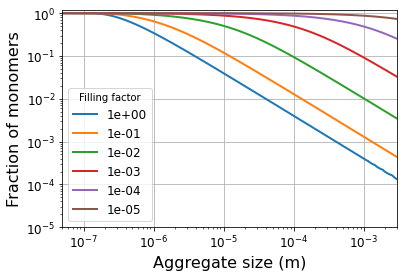

In [6]:
# To plot:
# + Total number of monomers in not exposed compared to exposed monomers as a function of home aggregate size.
# + Convert to fractions

def calcPexp(r, sa, phi):
    """
    Calculates the exposure probability at given radius r from the center of an aggregate of radius sa.
    """
    zCrit = 1e-7
    sMon = 5e-8
    
    
    if sa-r<=zCrit:
        pExp = 1
    else: 
        tau = 3/4*(sa-r-zCrit)/sMon*phi
        pExp = expn(2, tau) # We solve the exponential integral

    return pExp  
    
def fun(r, sa, phi=1e-1):
    """
    The exposed monomer density function: Number of monomers in a shell of thickness dr at radius r.
    """
    
    sMon = 5e-8

    nm = 3*phi/(4*np.pi*sMon**3)
    
    P = calcPexp(r, sa, phi)
    
    return 4*np.pi*nm*r**2*P
    


def calcIntegral(sa=5e-6, phi=1e-1):
    """
    Returns the number of monomers exposed in an aggregate of radius sa.
    """

    #delR = sa/1e4
    #rArr = np.arange(0,sa+delR, delR)
    #R = len(rArr)
    
    #fArr = np.array([fun(rArr[r], sa, phi) for r in range(R)])

    
    integral = quad(fun, 0, sa, (sa, phi), limit=500, epsabs=1.49e-24)
#     weights = np.ones(R)
#     weights[1:-1] = 2
#     #print(weights)
    
#     integral = delR/2*np.sum(weights*fArr)
    
#     if (phi==1 and sa>2e-3):
#         fig = figure()
#         frame = fig.add_subplot(1,1,1)
#         frame.semilogy(rArr, fArr)
#         frame.set_xlim(2.5e-3,3e-3)

    return integral[0]
    
def makeExpGraphs(pathdict, load=False):
    
    fig = figure(figsize=(6,4))
    frame = fig.add_subplot(1,1,1)
    
    S = 1000
    saArr = np.logspace(np.log10(5e-8),np.log10(1e-1),S)
    
    phi = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    P = len(phi)
    
    if load:
        nMonExp = pickle.load(open(pathdict["project"]+"Figures/ExposureFractions.pickle", "rb"))
    else:
        nMonExp = np.zeros((S,P))
    
    for p in range(P):
        sMon = 5e-8
        nm = 3*phi[p]/(4*np.pi*sMon**3)
        nMonTot = 4/3*np.pi*saArr**3*nm

        if not load:
            for s in range(S):
                print("Calculating integral ",s," for phi = ", phi[p], end="\r")
                nMonExp[s, p] = calcIntegral(saArr[s], phi[p])


        frame.loglog(saArr, nMonExp[:,p]/nMonTot, linewidth=2, label="{:.0e}".format(phi[p]))
        
    frame.set_ylabel("Fraction of monomers", fontsize=16)
    
    frame.tick_params(labelsize=12)
    frame.set_ylim(1e-5, 1.2)
    frame.set_xlim(saArr[0], 3e-3)
    frame.set_xlabel("Aggregate size (m)", fontsize=16)
    frame.grid()
    frame.legend(loc="lower left",title="Filling factor", fontsize=12)
    
    pickle.dump(nMonExp, open(pathdict["project"]+"Figures/ExposureFractions.pickle", "wb"))
    
     
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/20ExposureFractions."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 

    
    
    
makeExpGraphs(pathdict, load=True) 

In [40]:
sagg = 1e-5
aggnexp = (sagg/5e-8)**3*2*np.pi*(5e-8)**2*0.05
aggsurf = 4*np.pi*(sagg)**2

print(aggnexp/aggsurf)

5.000000000000001


# Section 3: Results

## + Section 3.1: How do non-local is local dust?

### ----- Fig: Population diagrams for nr vs nr0 and nz vs nz0 

NonLocalF3_cleaned3


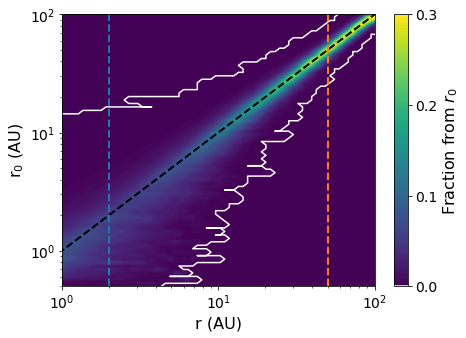

In [4]:
def makeOriginHist(analysis):
    
    R = analysis.disk.model.nx
    
    originGrid = np.zeros((R,R))
    
    # select all t=0 points for all monomers.
    r0DataSelect = analysis.monomerData[(analysis.monomerData["t"]==0)] 
    
    for r in range(R):
        print(r+1,"/",R, end="\r")
        # select all monomers which have visited this radius nr.
        rDataSelect = analysis.monomerData[(analysis.monomerData["nx"]==r)]  
        
        # Select monomer Id's
        monomerNums = np.unique(rDataSelect["n"].values).astype(int)
        
        # Iterate over monomers.
        flag = False
        for num in monomerNums:
            r0 = (((r0DataSelect[(r0DataSelect["n"]==num)])["nx"].values).astype(int))
            if len(r0)==1:
                originGrid[r0[0],r] += np.sum((rDataSelect[rDataSelect["n"]==num])["weights"].values)
                flag=True
                
        if flag: #with the flag we make sure we don't get too many zero division errors (we skip empty slices)
            originGrid[:,r] /= np.sum(originGrid[:,r]) #normalize to 1 for each radial slice. 
       
    
    return originGrid

def makeOriginPlot(analysis_name, disk200, loadPath="."):
           
    loadPath += "Simulations/NonLocal1"   
    
    grid = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_origins.analysis", "rb")) 
    print(analysis_name)
    grid[grid>0.3] = 0.3
    
    fig = figure(figsize=(7,5))
    frame = fig.add_subplot(1,1,1)
    cont = frame.contourf(disk200.model.x[:,0],disk200.model.x[:,0], grid, levels=np.linspace(0,.3,100))
    contl = frame.contour(cont, levels=[0,0.3], colors="w")
    cbar = fig.colorbar(cont, ticks=np.linspace(0,1,11))
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label="Fraction from $r_0$", size=16)
    cbar.add_lines(contl)
    
    frame.plot([0.08,150],[0.08,150], linewidth=2, color=(0,0,0),linestyle="--")
    
    frame.plot([2,2],[0.08,150], color=next(frame._get_lines.prop_cycler)['color'], 
               linewidth=2, linestyle="--")
    frame.plot([50,50],[0.08,150], color=next(frame._get_lines.prop_cycler)['color'], 
               linewidth=2, linestyle="--")
    
    #frame.grid()
    frame.set_xscale("log")
    frame.set_xlabel("r (AU)",fontsize=16)
    frame.set_yscale("log")
    frame.set_ylabel(r"r$_0$ (AU)",fontsize=16)
    frame.set_xlim(1,100)
    frame.set_ylim(0.5,100)
    frame.tick_params(labelsize=14)
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"31"+analysis_name+"OriginDiagram."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
      
makeOriginPlot(analysis_name, disk200, loadPath=pathdict["project"])

### ----- Fig: Zoom-in of origin diagram in two histograms

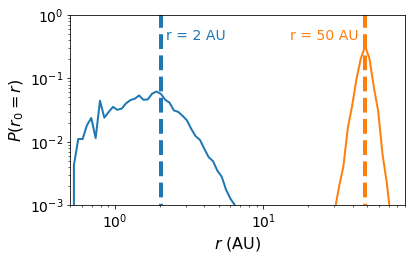

In [19]:
def makeHistROrigin(analysis_name, disk, loadPath="."):
    
    loadPath += "Simulations/NonLocal1"   
    grid = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_origins.analysis", "rb"))
    
    fig = figure(figsize=(6,3.5))
    
    frame = fig.add_subplot(1,1,1)
        
    dist = [2,50]
    D = len(dist)
    distpos = [1.1*2,15]
    
    for d in range(D):
        color = next(frame._get_lines.prop_cycler)['color']
        ind = np.argmin(abs(disk.model.x[:,0]-dist[d]))
        
        frame.loglog(disk.model.x[:,0], grid[:,ind], color=color, linewidth=2)
        frame.loglog([disk.model.x[ind,0],disk.model.x[ind,0]],[0,1], color=color, linestyle="--", linewidth=4)
        frame.annotate("r = {:.0f} AU".format(dist[d]), (distpos[d],0.4), color=color, fontsize=14)
        
    frame.set_xlim(.5,90)
    frame.set_ylim(1e-3,1)
    
    frame.set_xlabel(r"$r$ (AU)",fontsize=16)
    frame.set_ylabel(r"$P(r_0=r)$", fontsize=16)
    frame.tick_params(labelsize=14)
    frame.set_xscale("log")
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"31"+analysis_name+"OriginHists."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
      
    
    show()
    
makeHistROrigin(analysis_name, disk200, loadPath=pathdict["project"])

Species: H2O
rMin: 2.037304
Species: CO
rMin: 23.07284
Species: CO2
rMin: 4.894217
Species: CH4
rMin: 24.68198
Species: CH3OH
rMin: 2.037304
Species: NH3
rMin: 1.780318
Species: H2S
rMin: 5.600687
Species: SO2
rMin: 2.037304
Species: OCS
rMin: 4.894217
[55. 57. 70. 72. 93. 94.]
[0.3367858  0.42181205 0.9507032  0.9746143  1.         1.
 1.        ]


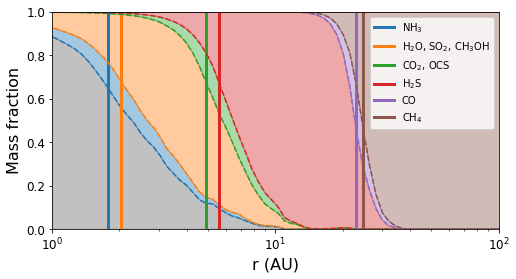

In [18]:
def makeChemicalOriginDiagram(analysis_name, disk, loadPath="."):
    
    loadPath += "Simulations/NonLocal1"   
    grid = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_origins.analysis", "rb"))
    
    fig = figure(figsize=(8,4))
    
    frame = fig.add_subplot(1,1,1)
        
    # Calculate the positions where the icelines are:
    S = len(disk.iceList)
    R = len(disk.model.x[:,0])
    
    # Find the iceline positions by 50% condensation position. Note that we store the indices.
    iceP = np.zeros(S)   

    for s in range(S):
        spIce = 10**(disk.data["iceAbun"+disk.iceList[s]])[:,0]
        spGas = 10**(disk.data["gasAbun"+disk.iceList[s]])[:,0]
        iceDom = np.where(spIce/spGas>0.5, np.ones(R), np.zeros(R))
        oneregarr = np.argwhere(iceDom>.99)

        maxice = oneregarr[-1]
        minice = oneregarr[0]
    
        iceP[s] = minice[0]
    
        print("Species:", disk.iceList[s])
        print("rMin:", disk.model.x[minice[0],0])
    
    iceP = np.unique(iceP)
    print(iceP)
    
    # Number of regions to discern:
    # 0 - Outside 1.78 AU (NH3)
    # 1 - Outside 2.04 AU (NH3, H2O, SO2, CH3OH)
    # 2 - Outside 4.89 AU (NH3, H2O, SO2, CH3OH, CO2, OCS)
    # 3 - Outside 5.60 AU (NH3, H2O, SO2, CH3OH, CO2, OCS, H2S)
    # 4 - Outside 23.07 AU (NH3, H2O, SO2, CH3OH, CO2, OCS, H2S, CO)
    # 5 - Outside 24.68 AU (NH3, H2O, SO2, CH3OH, CO2, OCS, H2S, CO, CH4)
    # 6 - Inside 1.78 (adds up to 1)
    
    labelList = [r"NH$_3$",r"H$_2$O, SO$_2$, CH$_3$OH", r"CO$_2$, OCS", r"H$_2$S", "CO", r"CH$_4$"]
    
    P = len(iceP)+1
    popData = np.zeros((R,P))
    
    colorList = [None]*P
    for p in range(P):
        if p==0:
            colorList[p] = (.4,.4,.4)
        else:
            colorList[p] = next(frame._get_lines.prop_cycler)['color']

    # Define the populations where the above conditions are valid.
    for p in range(P-1):
        
        popData[:,p] = np.sum(grid[0:int(iceP[p]),:], axis=0)
        frame.semilogx(disk.model.x[:,0], popData[:,p], color=colorList[p+1], linestyle="--")
        if p==0:
            frame.fill_between(disk.model.x[:,0], popData[:,p], y2=0, alpha=.4, color=colorList[p])
        else:
            frame.fill_between(disk.model.x[:,0], popData[:,p], popData[:,p-1], alpha=.4, color=colorList[p])
        
        frame.plot([disk.model.x[int(iceP[p]),0]]*2,[0,1], color=colorList[p+1], linewidth=3, label=labelList[p])
        
    
    popData[:,-1] = np.sum(grid, axis=0)
    print(popData[np.argmin(abs(3-disk.model.x[:,0])),:])
    frame.semilogx(disk.model.x[:,0], popData[:,-1], color=colorList[P-1], linestyle="--")
    frame.fill_between(disk.model.x[:,0], popData[:,-2], popData[:,-1], alpha=.4, color=colorList[-1])

    frame.set_xlim(1,100)
    frame.set_ylim(0,1)
    
    frame.set_xscale("log")
    frame.set_xlabel("r (AU)", fontsize=16)
    frame.set_ylabel("Mass fraction", fontsize=16)
    frame.tick_params(labelsize=12)
    frame.legend(fontsize=10)


#     for d in range(D):
#         color = next(frame._get_lines.prop_cycler)['color']
#         ind = np.argmin(abs(disk.model.x[:,0]-dist[d]))
        
#         frame.loglog(disk.model.x[:,0], grid[:,ind], color=color, linewidth=2)
#         frame.loglog([disk.model.x[ind,0],disk.model.x[ind,0]],[0,1], color=color, linestyle="--", linewidth=4)
#         frame.annotate("r = {:.0f} AU".format(dist[d]), (distpos[d],0.4), color=color, fontsize=14)

    
#     frame.set_xlabel(r"$r$ (AU)",fontsize=16)
#     frame.set_ylabel(r"$P(r_0=r)$", fontsize=16)
#     frame.tick_params(labelsize=14)
#     frame.set_xscale("linear")
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"31"+analysis_name+"ChemicalOrigin."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
      
    
    show()
    
makeChemicalOriginDiagram(analysis_name, disk200, loadPath=pathdict["project"])

## + Section 3.2 Where is local ice processing important for a given monomer? 

### ----- Fig: sAgg, zMon and zMon/sAgg over (r,z)

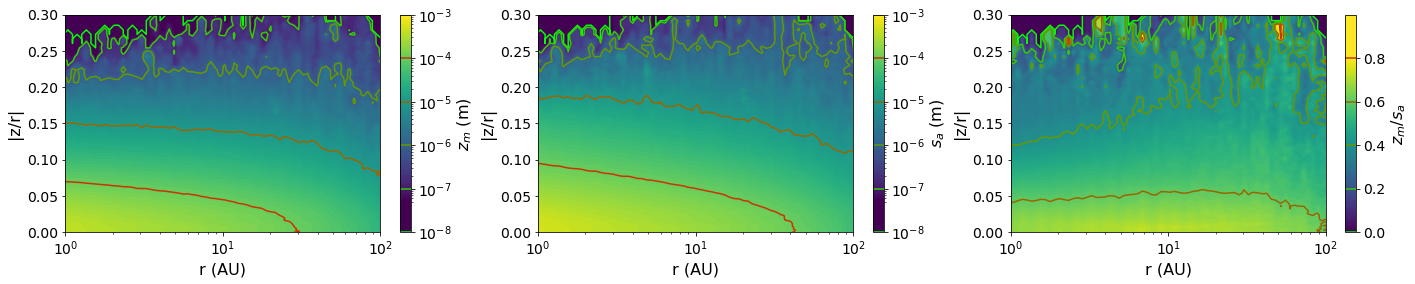

In [17]:
# Would probably be interesting for different background models? ---> Can be integrated over time, use RUN1
# Could be interesting to visit vFrag again? Since we now have multiple models...



def calcAVGzm(analysis_name, disk200, loadPath=".", quant="all"):
    
    loadPath += "Simulations/NonLocal1"
    
    C = 3
    
    #figList = [figure(figsize=(8,4)) for c in range(C)]
    fig = figure(figsize=(24,4))
    frameList = [fig.add_subplot(1,3,n+1) for n in range(C)]
    
    grid_zm = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_AVGzMon.analysis", "rb"))
    grid_sa = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_AVGsAgg.analysis", "rb"))
    ratio = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_AVGaggratio.analysis", "rb"))
    
    
    
    gridList = [grid_zm, grid_sa, ratio]
    
    levelList= (np.logspace(-8,-3,100),np.logspace(-8,-3,100),np.linspace(0,1,100))
    normList = (colors.LogNorm(vmin=5e-8, vmax=1e-3),colors.LogNorm(vmin=5e-8, vmax=1e-3),colors.Normalize(vmin=0, vmax=.8))
    tickList = ([10**n for n in range(-8,0)],[10**n for n in range(-8,0)],[n/5 for n in range(0,5)])
    colorList = [[n/5,(5-n)/5,0] for n in range(5)]
    
    labelList = [r"$z_m$ (m)",r"$s_a$ (m)", r"$z_m/s_a$"]
    contList = [None]*C
    contlList = [None]*C
    cbarList = [None]*C
    
    floorvals = [1e-8, 1e-8, 0]
    
    for c in range(C):
        (gridList[c])[np.where(np.isfinite(gridList[c]), False, True)] = floorvals[c]
        (gridList[c])[gridList[c]<floorvals[c]] = floorvals[c]
        
        contList[c] = frameList[c].contourf(disk200.model.x, disk200.model.z/disk200.model.x, gridList[c], 
                                            levels=levelList[c], norm=normList[c])
        if c==2:
            contlList[c] = frameList[c].contour(contList[c], levels=tickList[c], colors=colorList)
        else:
            contlList[c] = frameList[c].contour(contList[c], levels=tickList[c], colors=colorList)
        #frameList[c].clabel(contlList[c], fontsize=9, inline=True, fmt="%1.3e")
        
        cbarList[c] = fig.colorbar(contList[c], ticks=tickList[c], label=labelList[c], ax=frameList[c])
        cbarList[c].add_lines(contlList[c])
        
        cbarList[c].ax.tick_params(labelsize=14)
        cbarList[c].set_label(label=labelList[c], size=16)
    
        frameList[c].set_xscale("log")
        frameList[c].set_xlabel("r (AU)",fontsize=16)
        frameList[c].tick_params(labelsize=14)
        frameList[c].set_ylabel("|z/r|",fontsize=16)
        frameList[c].set_xlim(1,100)
        frameList[c].set_ylim(0,0.3)
        
    savenames = ["zm","sa","depthrat"]
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"32"+analysis_name+"."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
        
    show()
    
calcAVGzm(analysis_name, disk200, loadPath=pathdict["project"])

### ----- Fig: Corruption fraction over (r,z) (not in manuscript)

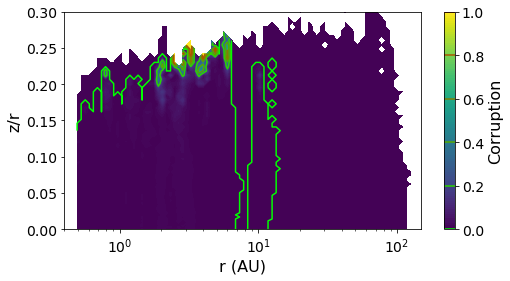

In [18]:
def calcTimeFraction(analysis_name, disk200, loadPath="."):
       
    loadPath += "Simulations/NonLocalF3"

    fig = figure(figsize=(8,4))
    
    grid = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_corruption.analysis", "rb")) 
    

    colorList = [[n/6,(6-n)/6,0] for n in range(6)]
    
    #grid[np.where(np.isfinite(grid), False, True)] = 1
    #grid[grid<1e-5] = 1
    
    frame = fig.add_subplot(1,1,1)
    cont = frame.contourf(disk200.model.x, disk200.model.z/disk200.model.x,grid, levels=np.linspace(0,1,100))
    contl = frame.contour(cont, levels=np.linspace(0,1,6), colors=colorList)
    cbar = fig.colorbar(cont, ticks=np.linspace(0,1,6), extend="max")
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label="Corruption", size=16)
    cbar.add_lines(contl)
    
    frame.set_xscale("log")
    frame.set_xlabel("r (AU)",fontsize=16)
    frame.tick_params(labelsize=14)
    frame.set_ylabel("|z/r|",fontsize=16)
    frame.set_xlim(0.4,150)
    frame.set_ylim(0,0.3)
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+analysis_name+"Corruption."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
    
    show()
    
calcTimeFraction(analysis_name, disk200, loadPath=pathdict["project"])

### ----- Fig: Fraction of time exposed

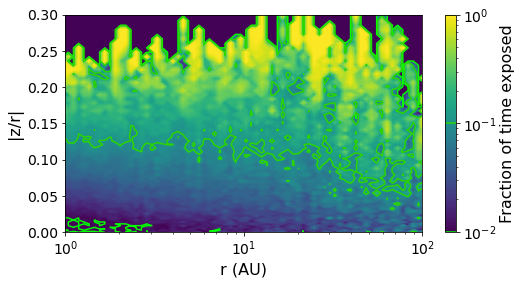

In [16]:
def calcTimeFraction(analysis_name, disk200, loadPath="."):
       
    loadPath += "Simulations/NonLocal1"

    fig = figure(figsize=(8,4))

   
    grid = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_exposed.analysis", "rb")) 
    

    colorList = [[n/6,(6-n)/6,0] for n in range(6)]
    
    grid[np.where(np.isfinite(grid), False, True)] = 1e-2
    grid[grid<1e-2] = 1e-2
    
    frame = fig.add_subplot(1,1,1)
    cont = frame.contourf(disk200.model.x,disk200.model.z/disk200.model.x,grid, levels=np.logspace(-2,0,100), norm=colors.LogNorm(vmin=1e-2, vmax=1e0))
    contl = frame.contour(cont, levels=np.logspace(-2,0,3), colors=colorList)
    cbar = fig.colorbar(cont, ticks=np.logspace(-2,0,3), extend="max")
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label="Fraction of time exposed", size=16)
    cbar.add_lines(contl)
    
    frame.set_xscale("log")
    frame.set_xlabel("r (AU)",fontsize=16)
    frame.tick_params(labelsize=14)
    frame.set_ylabel("|z/r|",fontsize=16)
    frame.set_xlim(1,100)
    frame.set_ylim(0,0.3)
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"32"+analysis_name+"Exposedness."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
    
    show()
    
calcTimeFraction(analysis_name, disk200, loadPath=pathdict["project"])

### Supplementary figure: Grain size distribution exploration at given r,z

 ------------------------------------------------------------------------ 
|                                                                        |
|                           Welcome to SHAMPOO                           |
|                                                                        |
|                      StocHAstic Monomer PrOcessOr                      |
|                                                                        |
|          Dynamical, collisional and ice processing since 2022          |
|                                                                        |
 ------------------------------------------------------------------------ 
Attempting to load parameters from folder:  /net/zach/data/users/moosterloo/PhD/Papers/ShampooSciencePaper//InputFiles/Section3NonLocal1
Attempt succesful!
Initializing model
Finished model initialization in 0.00 CPU s


NameError: name 'analysis' is not defined

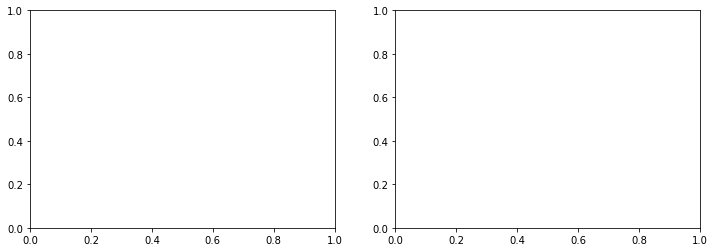

In [9]:
# See makePlotData.py
def findMaxGrain(analysis, r, z, disk200):
    """
    Finds maximum grain size given radial and vertical position in AU.
    """
    
    rInd = np.argmin(abs(disk200.model.x[:,0]-r))
    zInd = np.argmin(abs(disk200.model.z[rInd,:]-z))
    
    grainData = (analysis.monomerData[(analysis.monomerData["nx"]==rInd)&(analysis.monomerData["nz"]==zInd)])["sa"].values
    if len(grainData)>0:
        saMax = np.max(grainData)
    else:
        saMax = 0 
    
    return saMax
    
    
def maxStokes(analysis_name, disk200, loadPath="."):
    """
    Calculates the Stokes number for the mean home aggregate size in the disk midplane, for different heights above
    the disk midplane.
    """
    
    app = "Simulations/NonLocal1"

    gridList = pickle.load(open(loadPath+app+"/"+analysis_name+"NonLocalCalculations_AVGsAgg.analysis", "rb"))

    heights = [0]
    H = len(heights)
    
    fig = figure(figsize=(12,4))
    frameSA = fig.add_subplot(1,2,1)
    frameST = fig.add_subplot(1,2,2)
    
    model = shampoo.Model(disk=disk200, parameter_folder=loadPath+"/InputFiles/Section3NonLocal1")
    
    for h in range(H):
        rVals = disk200.model.x[:,0]*model.auTOm
        zVals = rVals*heights[h]
        
        S = len(rVals)
        dat_stop = np.zeros(S)
        dat_sagg = np.zeros(S)        
        
        
        for s in range(S):
            print(s,"/",S, end="\r")
            dat_sagg[s] = findMaxGrain(analysis, rVals[s]/model.auTOm, zVals[s]/model.auTOm, disk200)
            model.initGradients(size=dat_sagg[s])
            model.probeEnvironment(rVals[s]/model.auTOm, zVals[s]/model.auTOm, 0, inside_loop=False)
            dat_stop[s] = model.Stokes(0,rVals[s],zVals[s], size=dat_sagg[s], rhoMat=2094*float(model.paraDict["phi"]))
        frameSA.loglog(rVals/model.auTOm, dat_sagg, label="z/r = {:.2f}".format(heights[h]), linewidth=2,zorder=-1)
        frameST.loglog(rVals/model.auTOm, dat_stop, linewidth=2,zorder=-1)
        
        
            
            
  #  for d in range(D):
  #      color = ((D-d)/D,d/D,0)
  #      print(rVals_sagg[d,:])
  #      frame.loglog(rVals_sagg[d,:], rVals_stop[d,:],color=color, linewidth=2)
    
    for frame in [frameSA, frameST]:
        frame.set_xlabel("r (AU)", fontsize=16)
        frame.grid()
        frame.tick_params(labelsize=14)
        frame.set_xlim(0.01,1000)
    
    frameST.set_ylabel("Maximum Stokes number", fontsize=16)
    frameSA.set_ylabel("Maximum aggregate size", fontsize=16)
    frameSA.legend(fontsize=12, ncol=1)
    fig.tight_layout(pad=1)
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"31"+analysis_name+"StokesNumberSupport."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
      
    
maxStokes(analysis_name, disk200, loadPath=pathdict["project"])
    

## Supplementary figure: Additional grain size distribution probing?

In [25]:
def makeGrainSizeGrid(analysis, disk, r):
    # Check whether there is any relation with 
    
    R = disk.model.nx
    
    fx = figure()
    
    # Select the nearest index in the background model.
    rInd = np.argmin(abs(disk.model.x[:,0]-r))
    
    # Select data points at r.
    rDataSelect = analysis.monomerData[(analysis.monomerData["nx"]==rInd)]  
    
    # Look up all unique monomers by first limiting to the initial conditions.
    r0DataSelect = analysis.monomerData[(analysis.monomerData["t"]==0)] 
    # Select monomer Id's
    monomerNums = np.unique(rDataSelect["n"].values).astype(int)
    print("Number of monomers at this radius: ",len(monomerNums))
    
    
    flag1 = True
    M = len(monomerNums)
    m = 1
    
    for num in monomerNums:
        print(m,"/",M, end="\r")
        
        # Select the data for the histogram (note: this is at r=r)
        sa_data = (rDataSelect[(rDataSelect["n"].values==num)])["sa"].values
        weights = (rDataSelect[(rDataSelect["n"].values==num)])["weights"].values
        
        aux = fx.add_subplot(1,1,1)
        data_sa = aux.hist(sa_data, bins=np.logspace(np.log10(5e-8),-1,100), weights=weights)
    
        yVals_sa = data_sa[0]
        
        if flag1:
            xVals_sa = ((data_sa[1])[1::]+(data_sa[1])[0:-1])/2
            X = len(xVals_sa)
            originGrid = np.zeros((X,R))
            flag1 = False

        r0 = (((r0DataSelect[(r0DataSelect["n"]==num)])["nx"].values).astype(int))

        if len(r0)==1:
            originGrid[:,r0[0]] += yVals_sa
            
        m += 1
        
    #Lastly, we normalize every radial slice.
    for n in range(R):
        rSum = np.sum(originGrid[:,n])
        if rSum>0:
            originGrid[:,n] /= rSum
    
    
    
    return originGrid, xVals_sa
    

def calcAMAXR(disk):
    rhos = 2094 # aggregate density in kg/m3
    alphat = 1e-3 # turbulent alpha parameter

    sigma = 2*disk.model.sdg[:,0]*1e4/1e3
    cs = disk.model.soundspeed[:,0]*1e3
    ff = 1/2

    term1 = 2/(3*np.pi)
    term2 = sigma/(rhos*alphat)
    term3 = (1/cs)**2

    amaxr = ff*term1*term2*term3

    return amaxr # output in m
    
def makeGrainSizePlot(analysis, disk200, r=10, loadPath="."):
    """
    Check whether there is any correlation between r0 and the aggregate size at a given point.
    """
           
    loadPath += "Simulations/NonLocal1"   

    grid, xVals_sa = pickle.load(open(loadPath+"/"+analysis.name+"NonLocalCalculations_grainsizedist"+str(r)+".analysis", "rb")) 
 
    fig = figure(figsize=(12,8))
    frame = fig.add_subplot(1,1,1)
    maxval = np.max(grid)
    grid[grid<1e-3] = 1e-3
    cont = frame.contourf(analysis.disk.model.x[:,0],xVals_sa,grid, levels=np.logspace(np.log10(0.03),np.log10(maxval),101))
    #contl = frame.contour(cont, levels=[0,0.3], colors="r")
    cbar = fig.colorbar(cont, ticks=np.logspace(np.log10(0.03),np.log10(maxval),11))
    cbar.ax.tick_params(labelsize=14)
    #cbar.add_lines(contl)
    
    amax = calcAMAXR(disk200)
    
    #frame.loglog(disk200.model.x[:,0],amax/amax*1e-3, color=(1,1,1))
    frame.loglog(disk200.model.x[:,0],amax, color=(0,0,0))
    
    
    frame.plot([r,r],[5e-8,1e-1], linewidth=2, color=(0,0,0), linestyle="--")
    
    #frame.plot([0.08,200],[1,1], linewidth=2, color=(1,1,1))
    #frame.plot([0.08,200],[100,100], linewidth=2, color=(1,1,1))
    #frame.plot([100,100],[1,100], linewidth=2, color=(1,1,1))
    #frame.plot([1,1],[1,100], linewidth=2, color=(1,1,1))
    #frame.plot([0.08,150],[0.08,150], linewidth=2, color=(0,0,0),linestyle="--")
        
    #posplot = [2,8,20]
    #for pos in posplot:
    #    frame.plot([0.08,pos],[pos,pos], linewidth=2, color=(0.9,0.9,1),linestyle="--")
    #    frame.plot([pos,pos],[0.08,pos], linewidth=2, color=(0.9,0.9,1),linestyle="--")
    
    #frame.grid()
    
    frame.set_xscale("log")
    frame.set_xlabel("r$_0$ (AU)",fontsize=16)
    frame.set_yscale("log")
    frame.set_ylabel(r"$s_a$ (m)",fontsize=16)
    frame.set_xlim(1,100)
    frame.set_ylim(xVals_sa[0],xVals_sa[-1])
    frame.tick_params(labelsize=14)
    
makeGrainSizePlot(analysis, disk200, r=20, loadPath=pathdict["project"])

NameError: name 'analysis' is not defined

## Supplementary Figure: Comparison between amax and sagg

INFO: Calculate surface densities


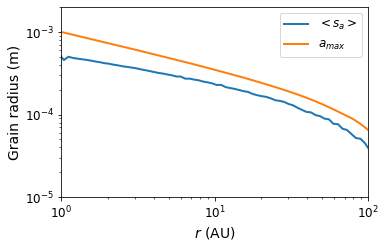

In [20]:
def calcAMAXR(disk):
    rhos = 2094 # aggregate density in kg/m3
    alphat = 1e-3 # turbulent alpha parameter

    sigma = 2*disk.model.sdg[:,0]*1e4/1e3
    cs = disk.model.soundspeed[:,0]*1e3
    ff = 1/2

    term1 = 2/(3*np.pi)
    term2 = sigma/(rhos*alphat)
    term3 = (1/cs)**2

    amaxr = ff*term1*term2*term3

    return amaxr # output in m


def compareESAGGandAMAXR(analysis_name, disk, pathdict):
    
    
    loadPath = pathdict["project"]+"Simulations/NonLocal1"   
    
    grid_sa = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_AVGsAgg.analysis", "rb"))
    
    
    amaxr = calcAMAXR(disk)
    saggr = grid_sa[:,0]
    rVals = disk.model.x[:,0]
    
    fig = figure(figsize=(5.5,3.5))
    frame = fig.add_subplot(1,1,1)
    
    frame.loglog(rVals, saggr, label=r"$<s_{a}>$", linewidth=2)
    frame.loglog(rVals, amaxr, label=r"$a_{max}$", linewidth=2)
            
    frame.tick_params(labelsize=12)
    frame.legend(fontsize=12)
    
    frame.set_xlim(1,100)
    frame.set_xlabel(r"$r$ (AU)", fontsize=14)
    
    frame.set_ylim(1e-5,2e-3)
    frame.set_ylabel("Grain radius (m)", fontsize=14)
        
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"33"+analysis_name+"sAggaMaxComparison."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
     

compareESAGGandAMAXR(analysis_name, disk200, pathdict)

# + Section 3.3: Ice composition: Local v.s. non-local

### ----- Fig: Non-local ice abundances analysis

In [16]:
print("Loading data...")
analysis = pickle.load(open(pathdict["simulation"]+"NonLocal1"+"/NonLocalB.analysis", "rb"))
analysis.name = "NonLocalB"
analysis_name = analysis.name
print("Data loaded ({:.0f} monomers)".format(analysis.monoNum))
print("Number of data points: ", len((analysis.monomerData["n"]).values))


Loading data...
Data loaded (64000 monomers)
Number of data points:  351426247


------------------------------------------------------------
H2O      89.65       75.04 0.5768822244443678
CO       0.00       0.00 0.07741487838897256
CO2      0.07       0.14 1.283556652650683
CH4      0.00       0.00 0.0775324655985563
CH3OH    1.04       0.89 0.5900488348133712
NH3      4.16       14.71 2.440204135596224
H2S      5.08       0.00 7.218440020880044e-18
SO2      0.00       9.22 9.863432483765102e+17
OCS      0.00       0.00 426.8975640406286
------------------------------------------------------------
H2O      90.43       87.10 0.6134494443801654
CO       0.00       0.00 0.13831094568966482
CO2      0.41       0.77 1.1977196907855638
CH4      0.00       0.00 0.13585126673897585
CH3OH    0.96       0.90 0.5989823041912368
NH3      3.28       5.51 1.070293799945346
H2S      4.92       0.00 1.485075020236736e-19
SO2      0.00       5.71 1.6908381355741184e+23
OCS      0.00       0.00 277.3195853586963
------------------------------------------------------------
H2O      

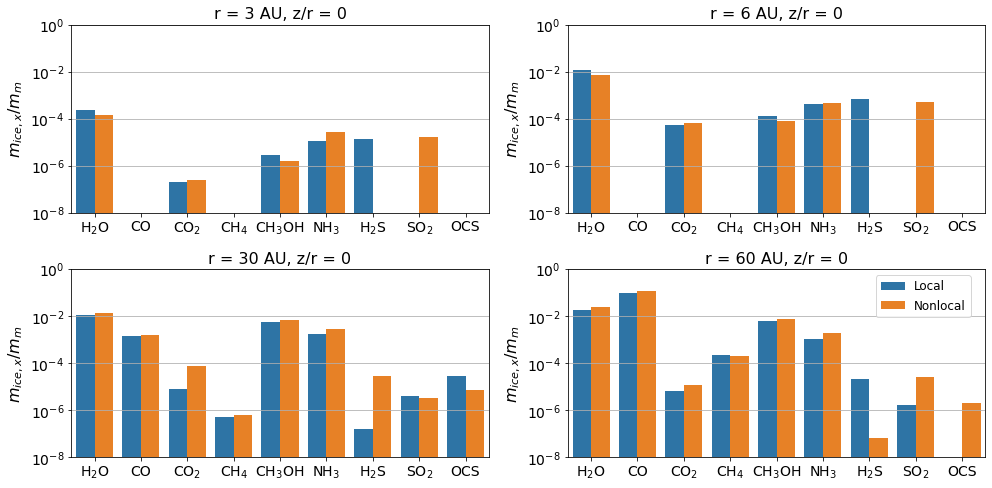

In [55]:
def makeBars(name, histframe, localData, nonlocalData, n, mode="absolute"):
    """
    Makes the bar diagram for a single panel.
    """
    
    labels = ["Abundance", "", "Species"]
    speciesList = ["H2O","CO","CO2","CH4","CH3OH","NH3","H2S","SO2","OCS"]


    species = [r'H$_2$O', 'CO', r"CO$_2$", r'CH$_4$', r'CH$_3$OH', r'NH$_3$', r'H$_2$S', r'SO$_2$', 'OCS']
    masses = [18.02, 28.01, 44.01, 16, 32.04, 17, 34, 64, 60.075] 
    
    forbidden = []

    for popsp in forbidden:
        speciesList.pop(speciesList.index(popsp))
    #print("------")
    if n in [0,1]:
        M = 2
    else:
        M = 2
    I = len(speciesList)

    dataVals = np.zeros((M*I, len(labels)), dtype="object")
    
    for m in range(M):
        for i in range(I):

            if m==0:
                abundance = localData[i]
                labelname = "Local"
            elif m==1:
                abundance = nonlocalData[i]
                labelname = "Nonlocal"
                
                
                #print(speciesList[i], localData[i], nonlocalData[i], nonlocalData[i]/localData[i])
                #print(localData[i]/np.sum(localData), nonlocalData[i]/np.sum(nonlocalData))
            ind = m*I+i# locate index in data array
            dataVals[ind,:] = [abundance, species[i], labelname]

    df = pd.DataFrame(dataVals, columns=labels)        


    barplotbank = sns.barplot(data=df, ax=histframe, x="", y="Abundance", hue="Species", 
                              saturation=.8, palette=sns.color_palette())


    if n==3:
        histframe.legend(bbox_to_anchor=(.98, 1), fontsize=12)
    else:
        histframe.legend([],[],frameon=False)


    histframe.set_yscale("log")
    histframe.set_ylim(1e-8, 1e0)
    #histframe.set_ylim(0, 1.1)
    histframe.grid(which='major', axis='y',zorder=-1)
    histframe.set_ylabel(r"$m_{ice,x}/m_m$", fontsize=16)
    #histframe.set_xlabel(r"$v_{frag}$", fontsize=16)
    histframe.tick_params(labelsize=14)

def fetchLocalIceComposition(iceData, n):
    """
    Converts the local monomer ice abundance data to a time-integated average (locations in AU).
    """
    
    I = len(analysis.disk.iceList)
    iceCompositions = [None]*I

    # --- iceData cheatsheet ---
    #iceData = np.zeros((len(tVals), maxNum, P, S))
    # Index 1: # of interpolated timesteps
    # Index 2: # of models per set
    # Index 3: # of plots (the 4 different locations)
    # Index 4: # of ices to compare

    for i in range(I):
        iceCompositions[i] = np.mean(iceData[:,:,n,i])
    
    return iceCompositions

def fetchNonLocalIceComposition(analysis, rPos,zPos):
    """
    Given radial and vertical position (both in AU), determine the local data sets from analysis instance. Also infers ice compositions.
    """
    
    I = len(analysis.disk.iceList)
    iceCompositions = [None]*I
    
    r = np.argmin(abs(analysis.disk.model.x[:,0]-rPos))
    z = np.argmin(abs(analysis.disk.model.z[r,:]-zPos*rPos))
       
    weights = (analysis.monomerData[(analysis.monomerData["nx"]==r) & (analysis.monomerData["nz"]==z)])["weights"]

    mMon = 4/3*np.pi*2094*(5e-8)**3
    
    for i in range(I):
        ice_data = (analysis.monomerData[(analysis.monomerData["nx"]==r) & (analysis.monomerData["nz"]==z)])[analysis.disk.iceList[i]]
        iceCompositions[i] = np.sum(ice_data*weights)/(np.sum(weights))
        iceCompositions[i] /= mMon
        
    return iceCompositions


def makeMasterBarPlot(disk200, name, mode="absolute"):
    """
    For now, we make panels where we compare average local and average non-local ice composition. Positions are:
       
    rLocs = [3,6,30,60]
    zLocs = [0,0,0,0] in units of z/r!!

    """
    
    # Load the local data
    #iceData = pickle.load(open(pathdict["simulation"]+"Section31BGComparisonJuly2023/plot.data", "rb"))
    #print(iceData.shape)
    rLocs = [3,6,30,60]
    zLocs = [0,0,0,0] # in units of z/r!!  
    N = len(zLocs)
    
    fig = figure(figsize=(14,7))
    frameList = [None]*N
    
    for n in range(N):
        print("--"*30)
        L_ice, NL_ice = pickle.load(open(pathdict["simulation"]+"Section33BGComparison/"+name+"histogramData"+str(n)+".analysis", "rb"))   
        
        S = len(disk200.iceList)
        for s in range(S):
            print(disk200.iceList[s], " "*(7-len(disk200.iceList[s])), "{:.2f}".format(L_ice[s]/sum(L_ice)*100), " "*5,
                  "{:.2f}".format(NL_ice[s]/sum(NL_ice)*100), NL_ice[s]/L_ice[s])
        
        
        frameList[n] = fig.add_subplot(2,2,n+1) 
        makeBars(name, frameList[n], L_ice, NL_ice, n, mode)
        frameList[n].set_title("r = {:.0f} AU, z/r = {:.0f}".format(rLocs[n], zLocs[n]), fontsize=16)
    
    fig.tight_layout(pad=1.5)
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"33"+name+"NonlocalHistograms."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)     

makeMasterBarPlot(disk200, analysis_name, mode="absolute")             

In [61]:
nads = 2*1.5e19*4*np.pi*(5e-8)**2
nmol = 3e-4*2094*4/3*np.pi*(5e-8)**3/(1.66e-27*18e-3)

print(nads, nmol, nmol/nads)
# Some quick calculations to check in which regime we are molecule-wise. 
# We have more molecules than desorption sites.

942477.7960769377 11008191.125530502 11.680053547523432


# Section 3.4: Behaviour near icelines

### ----- Fig: Ices as a function of radial distance in the midplane

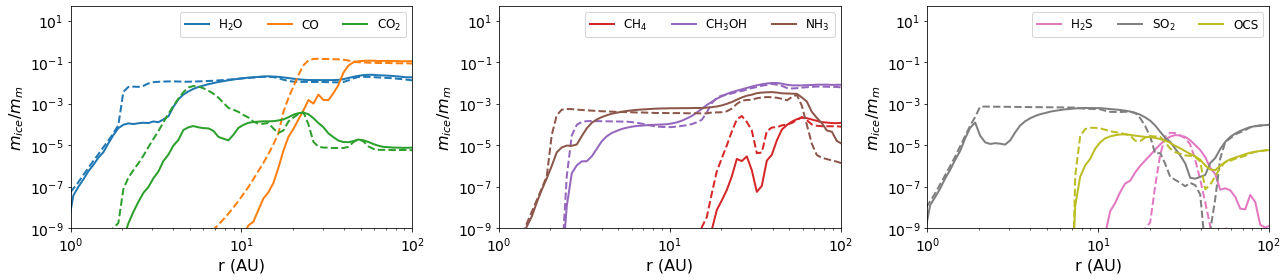

In [38]:
def showRadialIceBehaviour(analysis_name, disk, pathdict):
    
    
    fig = figure(figsize=(18,4))
    frame1 = fig.add_subplot(1,3,1)
    frame2 = fig.add_subplot(1,3,2)
    frame3 = fig.add_subplot(1,3,3)
    frameList = [frame1, frame2, frame3]
    
    abuns, abunp = pickle.load(open("./Figures/RadialAbundances"+analysis_name+".data", "rb")) 
    
    speciesList = ["H2O", "CO", "CO2", "CH4", "CH3OH", "NH3", "H2S", "SO2", "OCS"]
    speciesLabelList = [r'H$_2$O', 'CO', r"CO$_2$", r'CH$_4$', r'CH$_3$OH', r'NH$_3$', r'H$_2$S', r'SO$_2$', 'OCS']
    
    for n in range(3):  
        for m in range(3):
            color = next(frameList[0]._get_lines.prop_cycler)['color']
            frameList[n].loglog(disk.model.x[:,0], abuns[speciesList[3*n+m]], linewidth=2, color=color, label=speciesLabelList[3*n+m])
            frameList[n].loglog(disk.model.x[:,0], abunp[speciesList[3*n+m]], linewidth=2, color=color, linestyle="--")
    #print(disk.model.x[:,0], abuns[speciesList[0]])
    for n in range(3):
        frameList[n].set_xlim(1,1e2)
        frameList[n].set_ylim(1e-9,5e1)
        frameList[n].set_xlabel("r (AU)", fontsize=16)
        frameList[n].set_ylabel(r"$m_{ice}/m_m$", fontsize=16)
        frameList[n].legend(fontsize=12, ncol=3, loc="upper right")
        frameList[n].tick_params(labelsize=14)
    
    fig.tight_layout()
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"34MidplaneIcesComparison"+analysis_name+"."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)    
    
    show()
    
showRadialIceBehaviour(analysis_name, disk200, pathdict)   
    

### ----- Fig: Ices vs zMon at 3 and 5 AU.

['H2O', 'CO', 'CO2', 'CH4', 'CH3OH', 'NH3', 'H2S', 'SO2', 'OCS']
SO2/H2O, ice: 0.034941669867001
SO2/H2O, gas: 0.0004643856705856668
NH3/SO2, ice: 0.41640136650026244
NH3/SO2, gas: 0.11665996591733424
 ------------------------------------------------------------------------ 
|                                                                        |
|                           Welcome to SHAMPOO                           |
|                                                                        |
|                      StocHAstic Monomer PrOcessOr                      |
|                                                                        |
|          Dynamical, collisional and ice processing since 2022          |
|                                                                        |
 ------------------------------------------------------------------------ 
Attempting to load parameters from folder:  ./InputFiles/Section3NonLocal1
Attempt succesful!
Initializing model
Finished mo

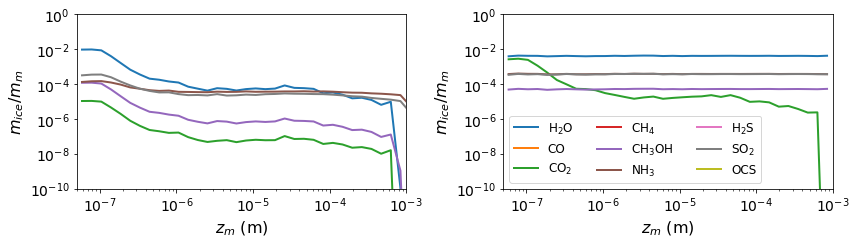

In [21]:
def makeIceAggregateCorrelationPanels(analysis_name, disk, pathdict):
    
    """
    Is there any correlation between ice composition/abundance and sa/zm?
    """   
        
    rPos = [3,5]
    P = len(rPos)
    
    fig = figure(figsize=(12,3.5))
    frameList = [fig.add_subplot(1, 2, n+1) for n in range(2)]
    
    zPos = [0.1]*P
    speciesLabelList = [r'H$_2$O', 'CO', r"CO$_2$", r'CH$_4$', r'CH$_3$OH', r'NH$_3$', r'H$_2$S', r'SO$_2$', 'OCS']
    
    for p in range(P):
        datstr = "r"+str(rPos[p])+"z"+str(zPos[p])
        iceCompositionsZM, binmeds = pickle.load(open(pathdict["project"]+"Figures/"+datstr+analysis_name+"IceAggregateCorrelationZM.data", "rb"))

        I = len(disk.iceList)
        
        abuns = np.zeros(I)
        comps = np.zeros(I)
        
        for i in range(I):
            if p==0:
                comps[i] = np.mean(iceCompositionsZM[binmeds<1e-7,i])
                abuns[i] = 10**(disk200.data["gasAbun"+disk.iceList[i]])[np.argmin(abs(3-disk.model.x[:,0])),0]
            frameList[p].loglog(binmeds, iceCompositionsZM[:,i], label=speciesLabelList[i], linewidth=2)
        
        
        if p==0:
            print(disk.iceList)
            print("SO2/H2O, ice:", comps[7]/comps[0])
            print("SO2/H2O, gas:", abuns[7]*64/(abuns[0]*18))
            print("NH3/SO2, ice:", comps[5]/comps[7])
            print("NH3/SO2, gas:", abuns[5]*17/(abuns[7]*64))
            
            model = shampoo.Model(disk=disk, parameter_folder="./InputFiles/Section3NonLocal1")
            model.probeEnvironment(3,0,0)
            model.monomer = shampoo.Monomer(model, 3, 0)
            model.initIces(0, 3, 0)
            
            iceList = {}
            for n in range(I):
                iceList[model.disk.iceList[n]] = (model.monomer.ice_sol[model.disk.iceList[n]])[0]
            
            adsH2O = model.rateAdsorption(0, 3*model.auTOm, 0, "H2O", iceList=iceList)
            adsSO2 = model.rateAdsorption(0, 3*model.auTOm, 0, "SO2", iceList=iceList)
            adsNH3 = model.rateAdsorption(0, 3*model.auTOm, 0, "NH3", iceList=iceList)
            
            tdsH2O = model.rateDesorptionThermal(0, 3*model.auTOm, 0, "H2O", iceList=iceList)
            tdsSO2 = model.rateDesorptionThermal(0, 3*model.auTOm, 0, "SO2", iceList=iceList)
            tdsNH3 = model.rateDesorptionThermal(0, 3*model.auTOm, 0, "NH3", iceList=iceList)
            
            print("H2O ads", adsH2O)
            print("SO2 ads", adsSO2)
            print("NH3 ads", adsNH3)
            
            print("H2O tds", 2*tdsH2O)
            print("SO2 tds", 2*tdsSO2)
            print("NH3 tds", 2*tdsNH3)
            
            print("SO2/H2O ads", adsSO2/adsH2O)
            print("NH3/SO2 ads", adsNH3/adsSO2)            
            print("SO2/H2O tds", tdsSO2/tdsH2O)
            print("NH3/SO2 tds", tdsNH3/tdsSO2)
            
            print("SO2/H2O del ice", (adsSO2-2*tdsSO2)/(adsH2O-2*tdsH2O))
            print("NH3/SO2 del ice", (adsNH3-2*tdsNH3)/(adsSO2-2*tdsSO2))
        
        #if zPos[p]==None:
        #    frameList[2*p].set_title("r = {:.0f} AU".format(rPos[p]), fontsize=16, x=1,y=1.05)
        #else:
        #    frameList[2*p].set_title("r = {:.0f} AU".format(rPos[p],zPos[p]), fontsize=16, x=1,y=1.05)

        frameList[p].set_xlabel(r"$z_m$ (m)", fontsize=16)
                
    for frame in frameList:
        frame.set_ylabel(r"$m_{ice}/m_m$", fontsize=16)
        frame.set_ylim(1e-10,1e0)
        frame.set_xlim(5e-8,1e-3)
        frame.tick_params(labelsize=14)
        
    frameList[1].legend(fontsize=12, ncol=3, loc="lower left")
        
    fig.tight_layout()
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"34"+analysis_name+"AggregateIceDistributions."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
        
makeIceAggregateCorrelationPanels(analysis_name, disk200, pathdict)       

### Supplementary figure: Ice amount v.s. sAgg/zMon

['H2O', 'CO', 'CO2', 'CH4', 'CH3OH', 'NH3', 'H2S', 'SO2', 'OCS']
SO2/H2O, ice: 0.034941669867001
SO2/H2O, gas: 0.0004643856705856668
NH3/SO2, ice: 0.41640136650026244
NH3/SO2, gas: 0.11665996591733424
 ------------------------------------------------------------------------ 
|                                                                        |
|                           Welcome to SHAMPOO                           |
|                                                                        |
|                      StocHAstic Monomer PrOcessOr                      |
|                                                                        |
|          Dynamical, collisional and ice processing since 2022          |
|                                                                        |
 ------------------------------------------------------------------------ 
Attempting to load parameters from folder:  ./InputFiles/Section3NonLocal1
Attempt succesful!
Initializing model
Finished mo

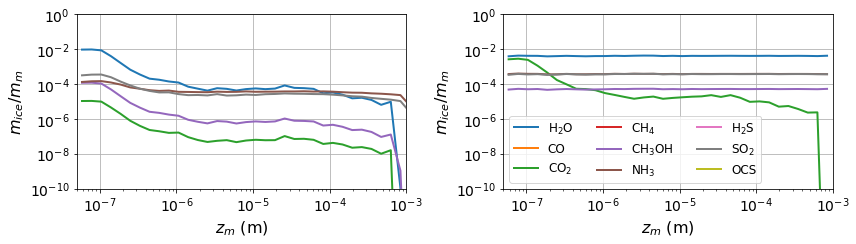

In [15]:
def makeIceAggregateCorrelationPanels(analysis_name, disk, pathdict):
    
    """
    Is there any correlation between ice composition/abundance and sa/zm?
    """   
        
    rPos = [3,5]
    P = len(rPos)
    
    fig = figure(figsize=(12,3.5))
    frameList = [fig.add_subplot(1, 2, n+1) for n in range(2)]
    
    zPos = [0.1]*P
    speciesLabelList = [r'H$_2$O', 'CO', r"CO$_2$", r'CH$_4$', r'CH$_3$OH', r'NH$_3$', r'H$_2$S', r'SO$_2$', 'OCS']
    
    for p in range(P):
        datstr = "r"+str(rPos[p])+"z"+str(zPos[p])
        iceCompositionsSA, binmeds = pickle.load(open(pathdict["project"]+"Figures/"+datstr+analysis_name+"IceAggregateCorrelationSA.data", "rb"))

        iceCompositionsZM, binmeds = pickle.load(open(pathdict["project"]+"Figures/"+datstr+analysis_name+"IceAggregateCorrelationZM.data", "rb"))

        I = len(disk.iceList)
        
        abuns = np.zeros(I)
        comps = np.zeros(I)
        
        for i in range(I):
            if p==0:
                comps[i] = np.mean(iceCompositionsZM[binmeds<1e-7,i])
                abuns[i] = 10**(disk200.data["gasAbun"+disk.iceList[i]])[np.argmin(abs(3-disk.model.x[:,0])),0]
            
            frameList[p].loglog(binmeds, iceCompositionsZM[:,i], label=speciesLabelList[i], linewidth=2)
        
        
        if p==0:
            print(disk.iceList)
            print("SO2/H2O, ice:", comps[7]/comps[0])
            print("SO2/H2O, gas:", abuns[7]*64/(abuns[0]*18))
            print("NH3/SO2, ice:", comps[5]/comps[7])
            print("NH3/SO2, gas:", abuns[5]*17/(abuns[7]*64))
            
            model = shampoo.Model(disk=disk, parameter_folder="./InputFiles/Section3NonLocal1")
            model.probeEnvironment(3,0,0)
            model.monomer = shampoo.Monomer(model, 3, 0)
            model.initIces(0, 3, 0)
            
            iceList = {}
            for n in range(I):
                iceList[model.disk.iceList[n]] = (model.monomer.ice_sol[model.disk.iceList[n]])[0]
            
            adsH2O = model.rateAdsorption(0, 3*model.auTOm, 0, "H2O", iceList=iceList)
            adsSO2 = model.rateAdsorption(0, 3*model.auTOm, 0, "SO2", iceList=iceList)
            adsNH3 = model.rateAdsorption(0, 3*model.auTOm, 0, "NH3", iceList=iceList)
            
            tdsH2O = model.rateDesorptionThermal(0, 3*model.auTOm, 0, "H2O", iceList=iceList)
            tdsSO2 = model.rateDesorptionThermal(0, 3*model.auTOm, 0, "SO2", iceList=iceList)
            tdsNH3 = model.rateDesorptionThermal(0, 3*model.auTOm, 0, "NH3", iceList=iceList)
            
            print("H2O ads", adsH2O)
            print("SO2 ads", adsSO2)
            print("NH3 ads", adsNH3)
            
            print("H2O tds", 2*tdsH2O)
            print("SO2 tds", 2*tdsSO2)
            print("NH3 tds", 2*tdsNH3)
            
            print("SO2/H2O ads", adsSO2/adsH2O)
            print("NH3/SO2 ads", adsNH3/adsSO2)            
            print("SO2/H2O tds", tdsSO2/tdsH2O)
            print("NH3/SO2 tds", tdsNH3/tdsSO2)
            
            print("SO2/H2O del ice", (adsSO2-2*tdsSO2)/(adsH2O-2*tdsH2O))
            print("NH3/SO2 del ice", (adsNH3-2*tdsNH3)/(adsSO2-2*tdsSO2))
        
        #if zPos[p]==None:
        #    frameList[2*p].set_title("r = {:.0f} AU".format(rPos[p]), fontsize=16, x=1,y=1.05)
        #else:
        #    frameList[2*p].set_title("r = {:.0f} AU".format(rPos[p],zPos[p]), fontsize=16, x=1,y=1.05)

        
        frameList[p].set_xlabel(r"$z_m$ (m)", fontsize=16)
                
    for frame in frameList:
        frame.set_ylabel(r"$m_{ice}/m_m$", fontsize=16)
        frame.set_ylim(1e-10,1e0)
        frame.set_xlim(5e-8,1e-3)
        frame.grid()  
        frame.tick_params(labelsize=14)
        
    frameList[1].legend(fontsize=12, ncol=3, loc="lower left")
        
    fig.tight_layout()
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"34"+analysis_name+"AggregateIceDistributions."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
        
makeIceAggregateCorrelationPanels(analysis_name, disk200, pathdict)       

### Supplementary figure: Ice abundance histogram 

In [ ]:
def exploreIceComposition(analysis_name, disk, pathdict, rPos):
    
    r = np.argmin(abs(rPos-disk.model.x[:,0]))
    z = 0
    
    iceHists, iceBins = pickle.load(open(pathdict["project"]+"Figures/IceProbing"+analysis_name+"r"+str(r)+"z"+str(0)+".data", "rb"))
    
    N = len(disk.iceList)
    
    fig = figure(figsize=(12,12))
    frame = fig.add_subplot(1,1,1)
    
    for n in range(N):
        
        frame.loglog(iceBins[disk.iceList[n]], iceHists[disk.iceList[n]], label=disk.iceList[n])
        
    
    frame.set_xlim(1e-11,1e-3)
    frame.set_xlabel(r"Ice mass $m_{mon}$",fontsize=16)
    frame.set_ylabel("Counts",fontsize=16)
    frame.legend()
    show()
    
exploreIceComposition("NonLocalFSMALL_clean", disk200, pathdict, 9)    

# Section 3.5: Elemental ratios

### ----- Fig: Elemental ratios as a function of radial distance 

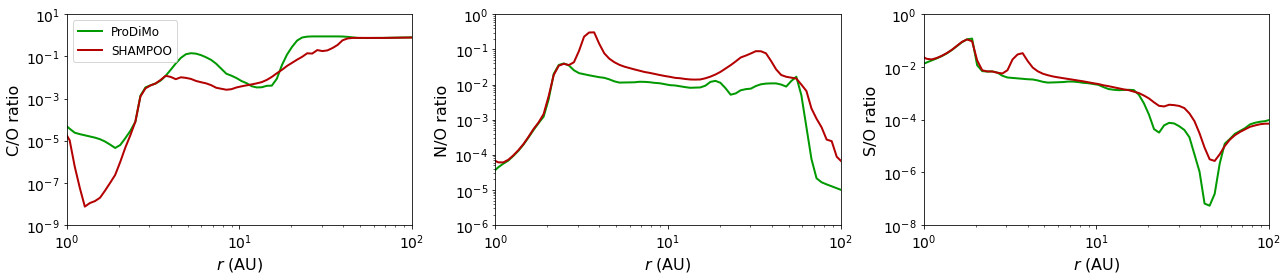

In [8]:
def findweights(sp, A, B):
    wA = 0
    wB = 0
    
    if A in sp:
        ind = sp.index(A)+1
        if ind<len(sp):
            if sp[ind].isnumeric():
                wA = int(sp[ind])
            else:
                wA = 1
        else:
            wA = 1
    if B in sp:
        ind = sp.index(B)+1
        if ind<len(sp):
            if sp[ind].isnumeric():
                wB = int(sp[ind])
            else:
                wB = 1
        else:
            wB = 1
    
    return wA, wB

def estimateRatio(analysis, A, B, pathdict):
    """
    Estimates the NUMBER ratio of element A and B.
    """
    
    I = len(analysis.disk.iceList)
    preA = [None]*I
    preB = [None]*I
    
    
    KB = 1.38064852e-23
    uTOkg = 1.660539067e-27 

    masses = {}
    dataName = np.loadtxt(pathdict["disk"]+"vFrag1/AdsorptionEnergies.in", dtype="str", comments="#", usecols=(0), encoding=None)
    dataNum = np.loadtxt(pathdict["disk"]+"vFrag1/AdsorptionEnergies.in", dtype="float", comments="#", usecols=(1,2), encoding=None)
        
    N = len(dataName)
    for n in range(N):
        masses["m"+dataName[n]] = dataNum[n,1] # in amu!   
    
    chnosM = [1.00797, 12.011, 14.0067, 15.9994, 32.06]
    chnos = ["H", "C", "N", "O", "S"]
    C = len(chnos)
    for c in range(C):
        masses["m"+chnos[c]] = chnosM[c]
    
    
    # First we fetch the appropriate prefactors
    for i in range(I):
        preA[i], preB[i] = findweights(analysis.disk.iceList[i], A, B)

    # Subsequently the average mass at each r for each species. convert to number.
    R = len(analysis.disk.model.x[:,0])
    massA = np.zeros(R)
    numA = np.zeros(R)
    massB = np.zeros(R)
    numB = np.zeros(R)   
    massApro = np.zeros(R)
    massBpro = np.zeros(R)
    numApro = np.zeros(R)
    numBpro = np.zeros(R)
    
    for r in range(R):
        print(r+1,"/",R, end="\r")
        locData = (analysis.monomerData[(analysis.monomerData["nx"]==r) & (analysis.monomerData["nz"]==0)])
        
        for i in range(I):
            # calculate mass of species from shampoo
            iceMass = locData[analysis.disk.iceList[i]]
            weights = locData["weights"]
            avgSPice = np.sum(iceMass*weights)/(np.sum(weights))
            
            # calculate mass of element A
            massA[r] += avgSPice*(preA[i]*masses["m"+A]/masses["m"+analysis.disk.iceList[i]])
            numA[r] += massA[r]/masses["m"+A]
            
            # "" element B
            massB[r] += avgSPice*(preB[i]*masses["m"+B]/masses["m"+analysis.disk.iceList[i]])
            numB[r] += massB[r]/masses["m"+B]
            
            # Calculate mass of species from prodimo
            prodimoNum = masses["m"+analysis.disk.iceList[i]]*10**((analysis.disk.data["iceAbun"+analysis.disk.iceList[i]])[r,0])
            massApro[r] += prodimoNum*(preA[i]*masses["m"+A]/masses["m"+analysis.disk.iceList[i]])
            numApro[r] += massApro[r]/masses["m"+A]
            
            # "" element B
            massBpro[r] += prodimoNum*(preB[i]*masses["m"+B]/masses["m"+analysis.disk.iceList[i]])
            numBpro[r] += massBpro[r]/masses["m"+B]
    
    
    massrat = {}
    numrat = {}
    
    massrat["shampoo"] = massA/massB
    numrat["shampoo"] = numA/numB
    massrat["prodimo"] = massApro/massBpro
    numrat["prodimo"] = numApro/numBpro
    
        
    
    
    return massrat, numrat
    


def makeRatioPlot(analysis, disk, pathdict):
    
    R = len(disk.model.x[:,0])
    
    S = 3
    A = ["C", "N","S"]
    B = ["O"]*S
    
    fig = figure(figsize=(6*S,4))
    frameList = [fig.add_subplot(1,S,s+1) for s in range(S)]
    
    xMaxs = [1e1, 1 ,1]
    xMins = [1e-9, 1e-6, 1e-8]
    
    for s in range(S):
        massrat, numrat = pickle.load(open("./Figures/"+A[s]+B[s]+"RatioFigures"+analysis_name+".data", "rb")) 
        
        frameList[s].loglog(disk.model.x[:,0], numrat["prodimo"], linewidth=2, color=(0,.6,0), label="ProDiMo")
        frameList[s].loglog(disk.model.x[:,0], numrat["shampoo"], linewidth=2, color=(.7,0,0), label="SHAMPOO")

        frameList[s].set_xlim(1e0,1e2)

        if s==0:
            frameList[s].legend(fontsize=12, loc="upper left")
        frameList[s].tick_params(labelsize=14)
        frameList[s].set_xlabel(r"$r$ (AU)",fontsize=16)
        frameList[s].set_ylabel(A[s]+"/"+B[s]+" ratio", fontsize=16)
        frameList[s].set_ylim(xMins[s],xMaxs[s])

    fig.tight_layout()
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"35MidplaneRatioComparison."+fmt, format=fmt, 
                    bbox_inches ='tight', pad_inches = 0.1) 
    
    
    show()
    
    
    
makeRatioPlot(analysis_name, disk200, pathdict)

# Section 4: Discussion

## Section 4.1: Diffusion timescales

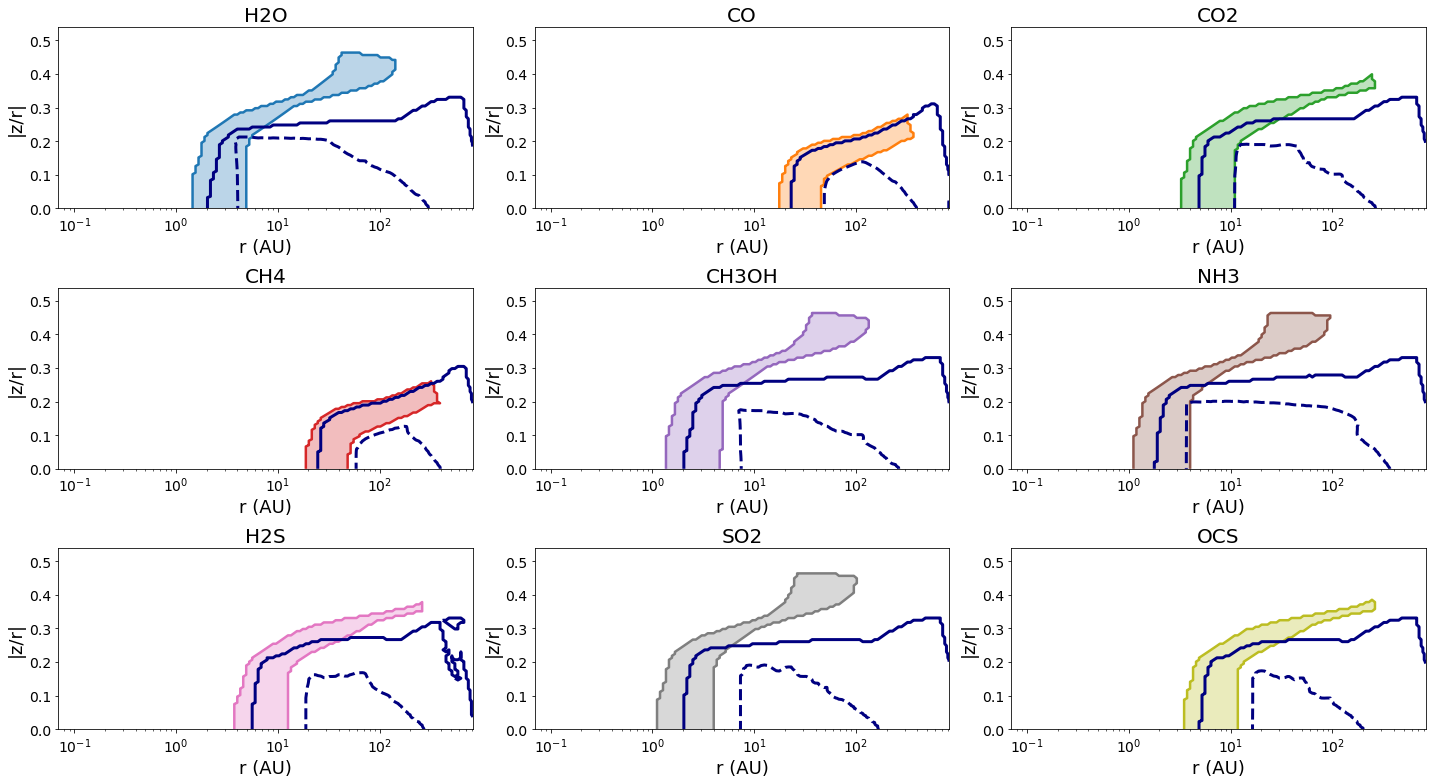

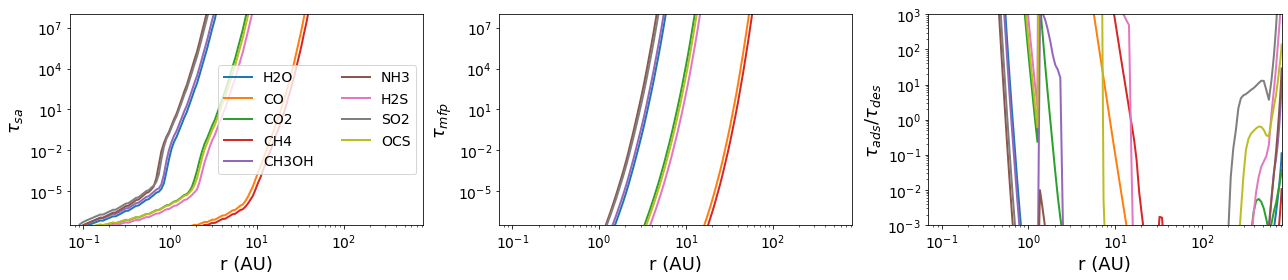

In [30]:
import shampoo

# Define a quick class where we can carry around variables a bit easier.
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams["legend.title_fontsize"] = 14


class TimescaleAnalysis:
    
    def __init__(self, disk, pathdict, species, phi):
        
        self.disk = disk
        self.pathdict = pathdict
        self.species = species
        
        # Adsorption energies and masses
        dataName = np.loadtxt(pathdict["disk"]+"/vFrag1"+"/AdsorptionEnergies.in", dtype="str", comments="#", usecols=(0), encoding=None)
        dataNum = np.loadtxt(pathdict["disk"]+"/vFrag1"+"/AdsorptionEnergies.in", dtype="float", comments="#", usecols=(1,2), encoding=None)
        found = False
        
        self.kb = 1.38064852e-23
        self.u = 1.660539067e-27 
        
        n = 0
        N = len(dataName)
        while not found and n<N:
            if (dataName[n]==self.species):
                self.Eads = dataNum[n,0]*self.kb
                self.mIce = dataNum[n,1]*self.u
                found = True
            else:
                n += 1
        self.sagg = 0
        self.phi = phi

    def calcEffTauDes(self, dustT=140):
        """
        Calculates the effective desorption timescale, assuming pure water ice mantle, i.e. tauDes*stickingFactor
        """
        alpha = 0.5
        beta = 0.11
        gamma =  0.042

        Nads = 1e19

        tanhArg = beta*(dustT-gamma*self.Eads/self.kb)
        sticking = alpha*(1-np.tanh(tanhArg))
    
        num = 2*Nads*self.Eads
        den = self.mIce*np.pi**2

        nu0 = np.sqrt(num/den)

        tauDes = sticking/nu0*np.exp(self.Eads/(dustT*self.kb))

        return tauDes

    def calcEffTauHop(self, dustT=140):
        """
        Calculates the thermal hopping timescale
        """
        alpha = 0.5
        beta = 0.11
        gamma =  0.042

        Nads = 1e19

        ratDiff = 0.5 # commonly used in literature (Ruaud+ 2016)

        num = 2*Nads*self.Eads
        den = self.mIce*np.pi**2

        nu0 = np.sqrt(num/den)

        tauDiff = 1/nu0*np.exp(ratDiff*self.Eads/(dustT*self.kb))

        return tauDiff

    def mfp(self):
        
        mfp = 4*5e-8/(3*self.phi)
        
        return mfp
    
    def calcEffTauCol(self, dustT=140):

        step = 1e-10
        mfp = self.mfp()
        tauDiff = self.calcEffTauHop(dustT=dustT)

        vCol = step/tauDiff
        #print("Diffusion velocity is:",vCol,"m/s")
        tauCol = mfp/vCol

        return tauCol


    def calculateDiffusionTimescales(self, Td):
        
        stoyr = 3600*24*365.25
        
        taucol = self.calcEffTauCol(Td)
        tauras = self.calcEffTauDes(Td)
        
        return (taucol, tauras)
    
    def calculateDiffusivity(self, Td):
        
        
        mfp = self.mfp()
        
        taucol, tauras = self.calculateDiffusionTimescales(Td)
       
        v0 = mfp/(taucol+tauras)
        
        diffusivity = mfp*v0
        
        return diffusivity
    
    def moleculeDiffusivity(self, Td):
        
        # Call on necessary environment properties the diffusivity
        
        # And intermediate quantities
        mfp = self.mfp()
        
        alpha = 0.5
        beta = 0.11
        gamma =  0.042
        step = 1e-10
        Nads = 1e19

        tanhArg = beta*(Td-gamma*self.Eads/self.kb)
        sticking = alpha*(1-np.tanh(tanhArg))
        
        num = 2*Nads*self.Eads
        den = self.mIce*np.pi**2

        nu0 = np.sqrt(num/den)
                
        numTot = nu0*mfp**2
        
        expArg = self.Eads/(self.kb*Td)

        term1 = (mfp/step)*np.exp(0.5*expArg)
        term2 = sticking*np.exp(expArg)
        
        denTot = term1+term2
        
        diffusivity = numTot/denTot
        
        return diffusivity
    
    
    def calculateDiffusionLimits(self, Td):
        
        diffusivity = self.calculateDiffusivity(Td)
        mfp = self.mfp()
        
        
        mfpTau = mfp**2/(6*diffusivity) # If diffusion is slower than this then molecules will not go anywhere
        saTau = self.sagg**2/(6*diffusivity)# If diffusion is faster than this then molecules can go out before anything happens
    
    
        return mfpTau, saTau

def findAMAX(disk, r, z):
    """
    r and z are the indices in the bg model for which we find the grain size which contains most mass.
    """
    
    M = len(disk.model.dust.asize)
    grainBins = np.zeros(M)
    
    for m in range(M):
         grainBins[m] = (10**(disk.data["rhoda"+str(m)]))[r,z]
            
    amax = disk.model.dust.asize[np.argmax(grainBins)]*1e-6
    
    return amax

def inferEvaporationTimescales(disk, r_in, z_in, species, size):
    
    r = r_in*1.496e11
    z = z_in*1.496e11
    t = 0
    
    mod = shampoo.Model(disk=disk, parameter_folder=pathdict["project"]+"InputFiles/Section3NonLocal1", supverbose=True, legacyIce=True)
        
    mod.monomer = shampoo.Monomer(mod, r_in, z_in, size=size)
        
    mod.initIces(0, r_in, z_in)
    mod.probeEnvironment(r_in, z_in, 0)
    
    tauads = mod.tauAds(t, r, z, size, species)
    taudes = mod.tauDes(t, r, z, size, species)
    
    return tauads, taudes


def makeDiffusionMap(disk, pathdict, calc=True, calcTaus=True, const=False):
    
    
    species = ["H2O", "CO", "CO2", "CH4", "CH3OH", "NH3", "H2S", "SO2", "OCS"]
    S = len(species)
    
    R = len(disk.model.x[:,0])
    Z = len(disk.model.x[0,:])
    xVals = disk.model.x
    yVals = disk.model.z/disk.model.x
    
    if const:
        constString = "Const"
    else:
        constString = ""
    
    stoyr = 365.25*24*3600
    
    if calc:
        mod = shampoo.Model(disk=disk, parameter_folder=pathdict["project"]+"InputFiles/Section3NonLocal1")
        mod.initGradients(size=1e-3)
        mod.initDensities()

        mfpTauArr = np.zeros((S,R,Z))
        saTauArr = np.zeros((S,R,Z))
        
        
        for s in range(S):
            diffanalysis = TimescaleAnalysis(disk, pathdict, species[s], 1)
            for r in range(R):
                for z in range(Z):
                    print("S = {:.0f}/{:.0f}, R = {:.0f}/{:.0f}".format(s+1, S, r+1, R), end="\r")
                    if const:
                        diffanalysis.sagg = 1e-3
                    else:
                        diffanalysis.sagg = findAMAX(disk, r, z)
                    mfpTauArr[s,r,z], saTauArr[s,r,z] = diffanalysis.calculateDiffusionLimits(disk.model.td[r,z])
    
        pickle.dump((mfpTauArr, saTauArr), open(pathdict["project"]+"/Figures/TauDiffRange"+constString+".data", "wb"))
    
    elif calcTaus:
        tauAdsArr = np.zeros((S,R,Z))
        tauDesArr = np.zeros((S,R,Z))
        
        mod = shampoo.Model(disk=disk, parameter_folder=pathdict["project"]+"InputFiles/Section3NonLocal1", supverbose=True)
        mod.initGradients(size=1e-3)
        mod.initDensities()
        
        for s in range(S):
            for r in range(R):
                print("S = {:.0f}/{:.0f}, R = {:.0f}/{:.0f}".format(s+1, S, r+1, R), end="\r")
                for z in range(Z):
                    if const:
                        agrain = 1e-3
                    else:
                        agrain = findAMAX(disk, r, z)
                    tauAdsArr[s,r,z], tauDesArr[s,r,z] = inferEvaporationTimescales(disk, disk.model.x[r,z], 
                                                                                    disk.model.z[r,z], species[s], agrain)
        
        tauRatArr = tauAdsArr/tauDesArr
        pickle.dump(tauRatArr, open(pathdict["project"]+"/Figures/TauRatArr"+constString+".data", "wb"))
    else:
        mfpTauArr, saTauArr = pickle.load(open(pathdict["project"]+"/Figures/TauDiffRange"+constString+".data", "rb"))
        tauRatArr = pickle.load(open(pathdict["project"]+"/Figures/TauRatArr"+constString+".data", "rb"))
      
    
    
    fig = figure(figsize=(20,11))
    frame = [fig.add_subplot(3, 3, s+1) for s in range(S)]
    
    figTau = figure(figsize=(18,4))
    frameTau = [figTau.add_subplot(1,3,n+1) for n in range(3)]
       
    
    falseArr = np.zeros((R,Z))
    trueArr = np.ones((R,Z))
        
    for s in range(S):
        color = next(frame[0]._get_lines.prop_cycler)['color']
        contArr1 = np.where((saTauArr[s,:,:]>1*stoyr), np.ones((R,Z)), np.zeros((R,Z)))
        contArr2 = 1#np.where((mfpTauArr[s,:,:]>1*stoyr), np.ones((R,Z)), np.zeros((R,Z)))
        contArr3 = np.where((mfpTauArr[s,:,:]<1e6*stoyr), np.ones((R,Z)), np.zeros((R,Z)))
        contArr4 = np.where((mfpTauArr[s,:,:]<saTauArr[s,:,:]), np.ones((R,Z)), np.zeros((R,Z)))
        contArr5 = 1#np.where((tauRatArr[s,:,:]<1), np.ones((R,Z)), np.zeros((R,Z)))
        contArr = contArr1*contArr2*contArr3*contArr4*contArr5
        
        cont = frame[s].contourf(xVals,yVals,contArr, levels=[.99,1], colors=[color,color], alpha=.3, linewidths=2)
        frame[s].contour(xVals,yVals,contArr, levels=[.99], colors=[color], linewidths=2.5)
        
        # Deal with the icelines
        spIce = 10**(disk.data["iceAbun"+species[s]])
        spGas = 10**(disk.data["gasAbun"+species[s]])
        iceDom = np.where(spIce/spGas>0.5, np.ones((R,Z)), np.zeros((R,Z)))
        
        if s==0:
            frame[s].contour(xVals,yVals,iceDom, levels=[.99], colors=[(0,0,.5)], linewidths=3)
            frame[s].contour(xVals,yVals,tauRatArr[s,:,:], levels=[.99], colors=[(0,0,.5)], linewidths=3, 
                             linestyles=["--"])
        else:
            frame[s].contour(xVals,yVals,iceDom, levels=[.99], colors=[(0,0,.5)], linewidths=3)
            frame[s].contour(xVals,yVals,tauRatArr[s,:,:], levels=[.99], colors=[(0,0,.5)], linewidths=3, linestyles=["--"])

        frame[s].set_xscale("log")
        frame[s].set_xlabel("r (AU)", fontsize=18)
        frame[s].set_ylabel("|z/r|", fontsize=18)
        frame[s].set_title(species[s],fontsize=20)
        frame[s].tick_params(labelsize=14)
        
        
    for arr in [mfpTauArr, saTauArr, tauRatArr]:
            np.nan_to_num(arr)
            arr[arr>1e40] = 1e40
    
    for s in range(S):
        color = next(frameTau[0]._get_lines.prop_cycler)['color']
        frameTau[0].loglog(xVals[:,0],saTauArr[s,:,0]/stoyr, color=color, label=species[s], linewidth=2)
        frameTau[1].loglog(xVals[:,0],mfpTauArr[s,:,0]/stoyr, color=color, linewidth=2)
        frameTau[2].loglog(xVals[:,0],tauRatArr[s,:,0]/stoyr, color=color, linewidth=2)
    
    
    for n in range(3):
        frameTau[n].set_xlabel("r (AU)", fontsize=18)
        frameTau[n].tick_params(labelsize=14)
        frameTau[n].set_xlim(xVals[0,0], xVals[-1,0])
        
    frameTau[0].set_ylabel(r"$\tau_{sa}$", fontsize=18)
    frameTau[1].set_ylabel(r"$\tau_{mfp}$", fontsize=18)
    frameTau[2].set_ylabel(r"$\tau_{ads}/\tau_{des}$", fontsize=18)
    frameTau[0].legend(fontsize=14, ncol=2)
    
    frameTau[0].set_ylim(1/stoyr, 1e8)
    frameTau[1].set_ylim(1/stoyr, 1e8)
    frameTau[2].set_ylim(1e-3, 1e3)
    
    figTau.tight_layout()
    fig.tight_layout()
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/41DiffusionStudy."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 

    
    show()
    
    
makeDiffusionMap(disk200, pathdict,calc=False, calcTaus=False, const=False)

    
    

## Section 4.2: Comparison to comets? 

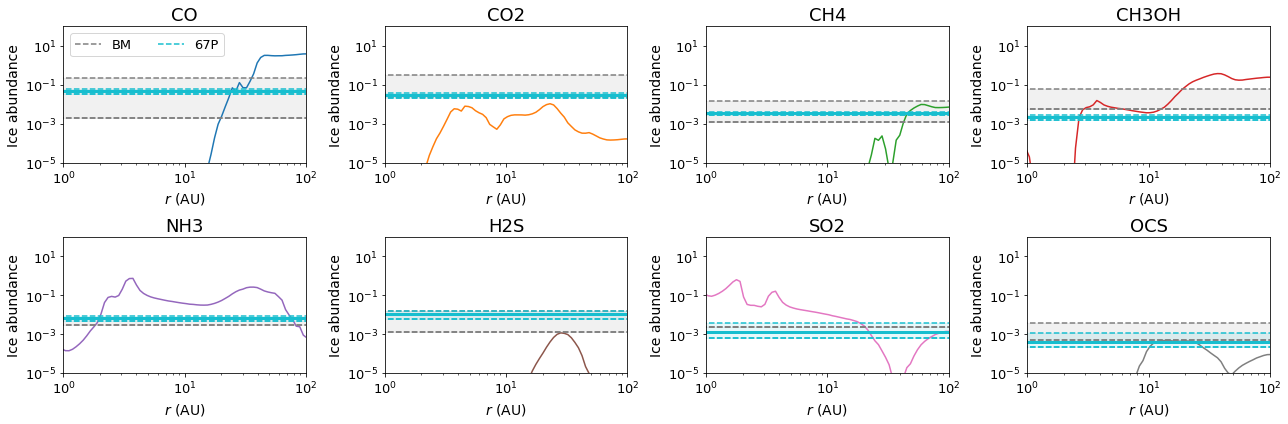

In [24]:
def defineMorvanData():
    # For now we use the maximum values
    
    data = {}
    # Data from Bockelee-Morvan 2017
    data["H2O_BM_max"] = 100
    data["CO_BM_max"] = 23
    data["CO2_BM_max"] = 30
    data["CH4_BM_max"] = 1.5
    data["CH3OH_BM_max"] = 6.3
    data["NH3_BM_max"] = .71
    data["H2S_BM_max"] = 1.5
    data["SO2_BM_max"] = .23
    data["OCS_BM_max"] = .40
    
    data["H2O_BM_min"] = 100
    data["CO_BM_min"] = 0.19960785140599907
    data["CO2_BM_min"] = 2.4691073056738286
    data["CH4_BM_min"] = 0.11971615313344343
    data["CH3OH_BM_min"] = 0.6022146719323003
    data["NH3_BM_min"] = 0.3004675067856649
    data["H2S_BM_min"] = 0.12992021535866013
    data["SO2_BM_min"] = 0.2303268576706231
    data["OCS_BM_min"] = 0.049690112755696486
    
    # Data from Rubin+ 2020 Tab 2
    data["H2O_67P_max"] = 100
    data["H2O_67P_med"] = 100
    data["H2O_67P_min"] = 100
    
    data["CO_67P_max"] = 4.7+1.4
    data["CO_67P_med"] = 4.7
    data["CO_67P_min"] = 4.7-1.4
    
    data["CO2_67P_max"] = 3.1+0.9
    data["CO2_67P_med"] = 3.1
    data["CO2_67P_min"] = 3.1-0.9
    
    data["CH4_67P_max"] = 0.34+0.07
    data["CH4_67P_med"] = 0.34
    data["CH4_67P_min"] = 0.34-0.07
    
    data["CH3OH_67P_max"] = 0.21+0.06
    data["CH3OH_67P_med"] = 0.21
    data["CH3OH_67P_min"] = 0.21-0.06

    data["NH3_67P_max"] = 0.67+0.2
    data["NH3_67P_med"] = 0.67
    data["NH3_67P_min"] = 0.67-0.2
    
    data["H2S_67P_max"] = 1.10+0.46
    data["H2S_67P_med"] = 1.10
    data["H2S_67P_min"] = 1.10-0.46
    
    data["SO2_67P_max"] = 0.127+0.254
    data["SO2_67P_med"] = 0.127
    data["SO2_67P_min"] = 0.127-0.064
    
    data["OCS_67P_max"] = 0.041+0.082
    data["OCS_67P_med"] = 0.041
    data["OCS_67P_min"] = 0.041-0.020
    
    return data 

def makeCometComparison(disk, analysis_name, pathdict, rIn=1, rOut=100, datArr=[]):
        
    abuns, abunp = pickle.load(open("./Figures"+"/RadialAbundances"+analysis_name+".data", "rb")) 
    
    comDat = defineMorvanData()
    
    S = len(disk.iceList)

    fig = figure(figsize=(18,6))
    frameList = [fig.add_subplot(2,4,s+1) for s in range(S-1)]
    
    rInD = np.argmin(abs(rIn-disk.model.x[:,0]))-1
    rOutD = np.argmin(abs(rOut-disk.model.x[:,0]))+1
    rVals = disk.model.x[rInD:rOutD, 0]

    molarMasses = [18, 28, 44, 16, 32, 17, 34, 64, 60]
    
    colorList = [next(frameList[0]._get_lines.prop_cycler)['color'] for c in range(30)]
    
    for s in range(1,S):        
        color = colorList[s-1]
        frameList[s-1].semilogy(rVals, (abuns[disk.iceList[s]])[rInD:rOutD]*molarMasses[0]/((abuns["H2O"])[rInD:rOutD]*molarMasses[s]), color=color)
        frameList[s-1].set_title(disk.iceList[s], fontsize=18)
        
        for item in datArr:
            if item=="BM":
                compColor = colorList[S-2]
            elif item=="67P":
                compColor = colorList[S]
                frameList[s-1].plot(rVals, comDat[disk.iceList[s]+"_"+item+"_"+"med"]/100*np.ones(len(rVals)), color=compColor, linestyle="-", linewidth=3)

                
            frameList[s-1].plot(rVals, comDat[disk.iceList[s]+"_"+item+"_"+"max"]/100*np.ones(len(rVals)), color=compColor, linestyle="--")
            frameList[s-1].plot(rVals, comDat[disk.iceList[s]+"_"+item+"_"+"min"]/100*np.ones(len(rVals)), color=compColor, linestyle="--")
            
            
            if s==1:
                frameList[s-1].plot(rVals, comDat[disk.iceList[s]+"_"+item+"_"+"min"]/100*np.ones(len(rVals)), color=compColor, linestyle="--", label=item)
            else:
                frameList[s-1].plot(rVals, comDat[disk.iceList[s]+"_"+item+"_"+"min"]/100*np.ones(len(rVals)), color=compColor, linestyle="--")
            
            
            miny = comDat[disk.iceList[s]+"_"+item+"_"+"min"]/100
            maxy = comDat[disk.iceList[s]+"_"+item+"_"+"max"]/100

            xcoords = [rVals[0], rVals[0], rVals[-1], rVals[-1], rVals[0]]
            ycoords = [miny, maxy, maxy, miny, miny]

            frameList[s-1].fill(xcoords,ycoords, color=compColor, alpha=.1)

        frameList[s-1].set_ylim(1e-5,1e2)
        frameList[s-1].set_xlim(1,100)
        frameList[s-1].set_xscale("log")
        frameList[s-1].tick_params(labelsize=13)
        frameList[s-1].set_ylabel("Ice abundance", fontsize=14)
        frameList[s-1].set_xlabel(r"$r$ (AU)", fontsize=14)
    
    frameList[0].legend(fontsize=13, ncol=2)
    
    fig.tight_layout()
    
makeCometComparison(disk200, analysis_name, pathdict, datArr=["BM","67P"])

# Appendix A: Background Disk Model

## ----- Physical Disk Structure (not in manuscript)

PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...


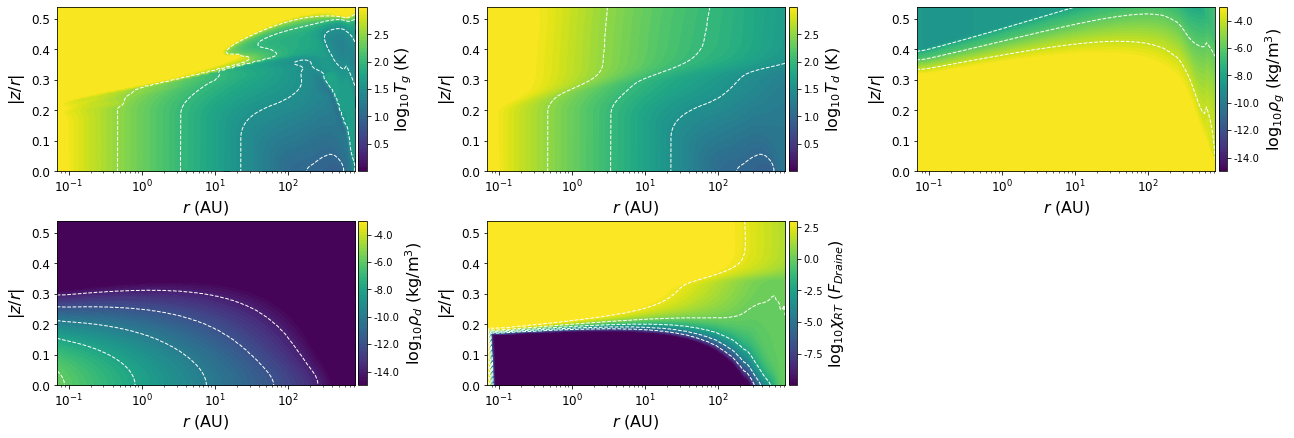

In [5]:
mpl.rcParams['legend.fontsize'] = 16
def makeBackgroundModelOverviewBasicStructure(disk, pathdict):
    time = 2e5
    #disk = shampoo.Disk(species=["H2O", "CO", "CO2", "CH4", "NH3", "H2S"], folder="./shampooBackground", modelName="ProDiMo.out", 
    #                     t_index="{:03d}".format(5))
    
    fig = figure(figsize=(18,6))
    
    frameLabel = [r"$\log_{10}T_g$ (K)", r"$\log_{10}T_d$ (K)", r"$\log_{10}\rho_g$ (kg/m$^3$)", r"$\log_{10}\rho_d$ (kg/m$^3$)", 
                  r"$\log_{10}\chi_{RT}$ ($F_{Draine}$)"]
    frameList = [fig.add_subplot(2,3,n) for n in range(1,6)]
    frameQuant = [disk.model.tg, disk.model.td, disk.model.nd*1e3, disk.model.rhod*1e3, disk.model.chiRT]
    frameLims = [[1e0,1e3],[1e0,1e3],[1e-15, 1e-3],[1e-15, 1e-3],[1e-10,1e3]]
    
    for n in range(5):
        
        lims = frameLims[n]
        (frameQuant[n])[frameQuant[n]>lims[1]] = lims[1]
        (frameQuant[n])[frameQuant[n]<lims[0]] = lims[0]
        
        pp = pplot.Plot(None, fs_legend=16)
        pp.plot_cont(disk.model, frameQuant[n], label=frameLabel[n], zlog=True, grid=False, zlim=frameLims[n], zr=True, clevels=None, 
                     clabels=None, contour=True, extend='neither', oconts=None, acont=None, acontl=None, nbins=70, bgcolor=None, 
                     cb_format='%.1f', scalexy=[1, 1], patches=None, rasterized=False, returnFig=False, fig=fig, ax=frameList[n], movie=False)
        #colorbar.set_label(frameLabel[n], fontsize=16)
        frameList[n].tick_params(labelsize=12)
        frameList[n].set_xlabel("$r$ (AU)", fontsize=16)
        frameList[n].set_ylabel("$|z/r|$",fontsize=16)
        #frameList[n].
    
    #fig.suptitle("Disk structure at t={:.2e} yr".format(time), fontsize=16, y=1.01)
    fig.tight_layout(pad=.4)
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"AA_{:.2e}".format(time)+"BackgroundModelStructure."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)    

makeBackgroundModelOverviewBasicStructure(disk200, pathdict)

## ----- Chemical disk structure

12278030176.7
600562020.4862
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...


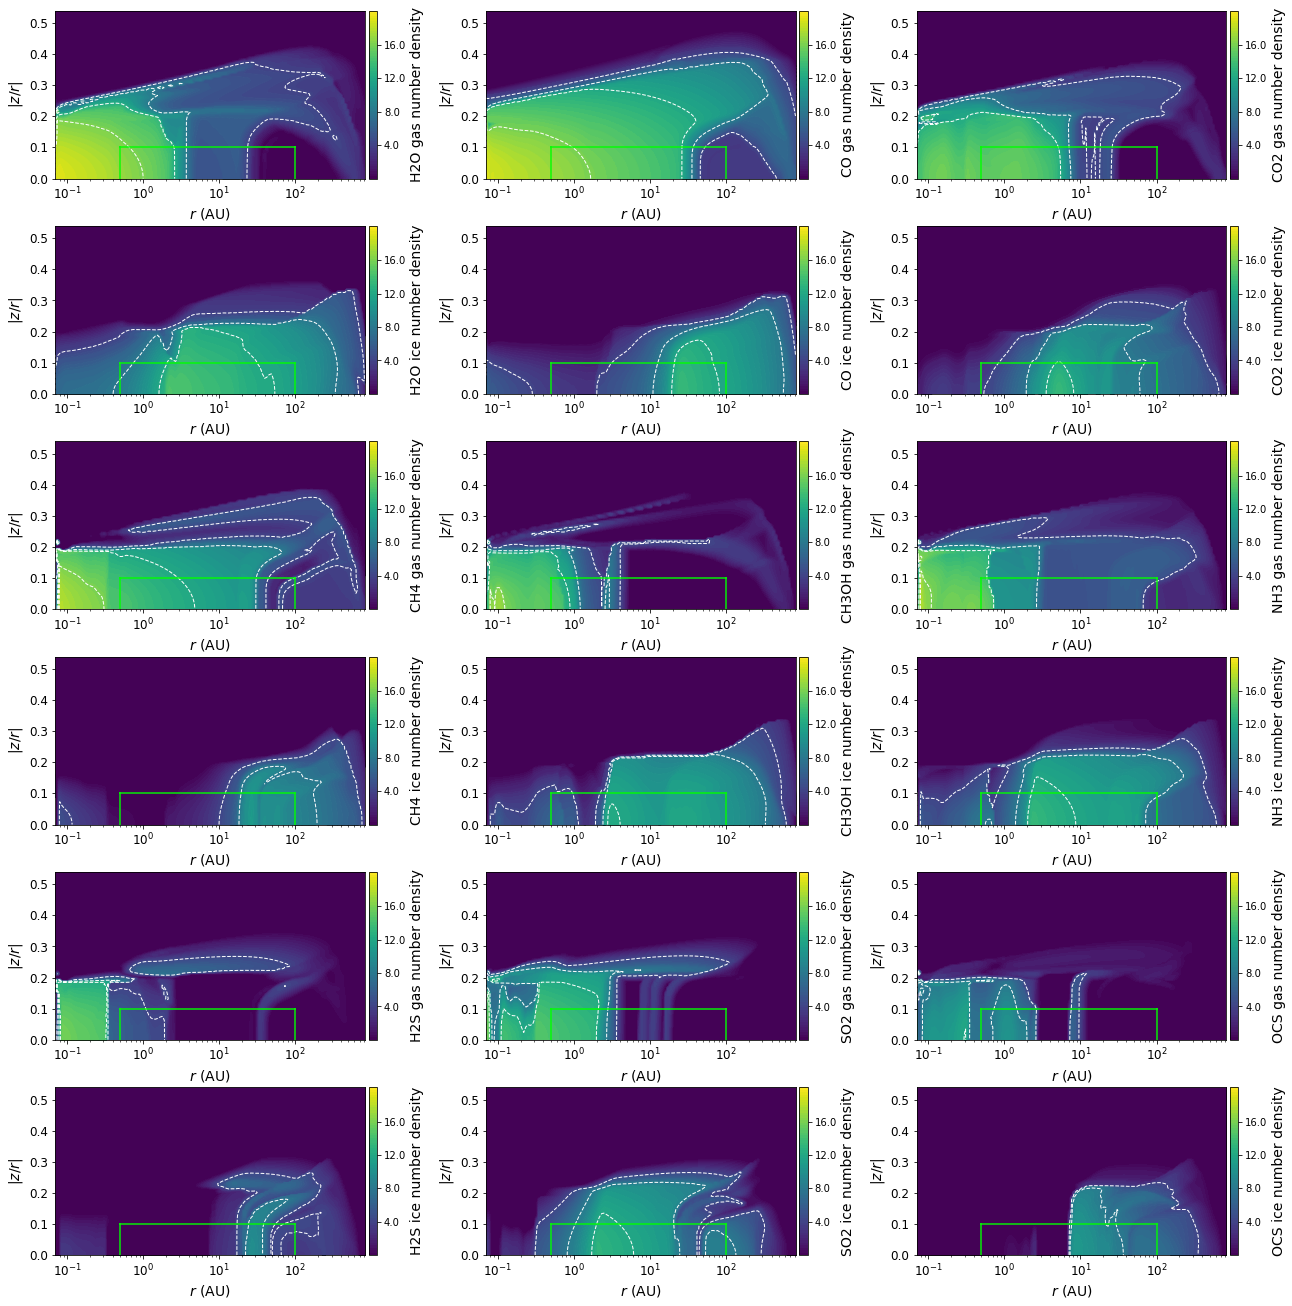

In [28]:
def plotChemicalDiskProperties(disk, pathdict):
    time = 2e5
    #disk = shampoo.Disk(species=["H2O", "CO", "CO2", "CH4", "NH3", "H2S"], folder="./shampooBackground", modelName="ProDiMo.out", 
    #                     t_index="{:03d}".format(5))
    
    
    frameLabel = disk.species
    fig = figure(figsize=(18,3*6))
    frameList = [fig.add_subplot(int(np.ceil((len(frameLabel)*2)/3)),3,n) for n in range(1,len(frameLabel)*2+1)]
    frameQuant = [None]*len(frameList)
    frameLabels = [None]*len(frameQuant)
    
    blockno = 0
    
    
    for n in range(len(disk.species)):

        indexGas = disk.model.spnames[frameLabel[n]]
        frameQuant[blockno*6+n%3] = disk.model.nmol[:,:,indexGas]*1e6
        frameLabels[blockno*6+n%3] = frameLabel[n]+" gas number density"
        #print(frameLabels[n],":","{:.2e}".format(disk.model.nmol[np.argmin(abs(10-disk.model.x[:,0])),0,indexGas]*1e6))

        indexIce = disk.model.spnames[frameLabel[n]+"#"]
        frameQuant[blockno*6+n%3+3] = disk.model.nmol[:,:,indexIce]*1e6
        frameLabels[blockno*6+n%3+3] = frameLabel[n]+" ice number density"
        
        if (n+1)%3==0:
            blockno += 1
    
    print((frameQuant[2])[np.argmin(abs(disk.model.x[:,0]-25)),0]+(frameQuant[5])[np.argmin(abs(disk.model.x[:,0]-25)),0])
    print((frameQuant[2])[np.argmin(abs(disk.model.x[:,0]-30)),0]+(frameQuant[5])[np.argmin(abs(disk.model.x[:,0]-30)),0])
    
    #print(frameQuant)
    for n in range(len(frameQuant)):
        
                
        lims = [1,1e20]
        (frameQuant[n])[frameQuant[n]>lims[1]] = lims[1]
        (frameQuant[n])[frameQuant[n]<lims[0]] = lims[0]
        
        pp = pplot.Plot(None, fs_legend=14)
        pp.plot_cont(disk.model, frameQuant[n], label=frameLabels[n], zlog=True, grid=False, zlim=lims, zr=True, clevels=None, 
                     clabels=None, contour=True, extend='neither', oconts=None, acont=None, acontl=None, nbins=70, bgcolor=None, 
                     cb_format='%.1f', scalexy=[1, 1], patches=None, rasterized=False, returnFig=False, fig=fig, ax=frameList[n], movie=False)

        
        boxColor = (0,1,0)
        alpha = .7
        frameList[n].semilogx([.5,100],[0.1,0.1], color=boxColor, linewidth=2, alpha=alpha)
        frameList[n].plot([.5,.5],[0,0.1], color=boxColor, linewidth=2, alpha=alpha)
        frameList[n].plot([100,100],[0,0.1], color=boxColor, linewidth=2, alpha=alpha)
        
        
        frameList[n].tick_params(labelsize=12)
        frameList[n].set_xlabel("$r$ (AU)", fontsize=14)
        frameList[n].set_ylabel("$|z/r|$",fontsize=14)

   # fig.suptitle("Disk abundances at t={:.2e} yr".format(time), fontsize=16, y=1.01)
    fig.tight_layout(pad=.4)
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"AABackgroundModelAbundances."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 

plotChemicalDiskProperties(disk200, pathdict)


# Appendix C: Variation of physical conditions in grid cell

In [ ]:
print("Loading data...")
analysis = pickle.load(open(pathdict["simulation"]+"NonLocalF3"+"/NonLocalSmall.analysis", "rb"))
analysis.name = "NonLocalSmall"
analysis_name = analysis.name
print("Data loaded ({:.0f} monomers)".format(analysis.monoNum))
print("Number of data points: ", len((analysis.monomerData["n"]).values))

In [ ]:
def makeCompArr(dArr, gArr, nxArr, nzArr, absolute=False):
    """
    Compares the environment from dArr with the environment at points (nxArr, nzArr) in gArr.
    """
    T = len(dArr)
    
    diffArr = np.zeros(T)
    
    for t in range(T):
        rInd = int(nxArr[t])
        zInd = int(nzArr[t])
        #if t in [0,30,80]:
        #    print(dArr[t], gArr[rInd, zInd])
        if absolute:
            diffArr[t] = abs(dArr[t]-gArr[rInd, zInd])
        else:
            diffArr[t] = abs(dArr[t]-gArr[rInd, zInd])/gArr[rInd, zInd]
        
    return diffArr
    
def showDiscreteEffects(disk, analysis, modno):
    
    keyList = ["t","r", "z", "rhog","rhod","Tg","Td"]
    titleList = [r"$|\Delta r/r|$", r"$|\Delta (z/r)/(z/r)|$", r"$|\Delta \rho_g/\rho_g|$",r"$|\Delta\rho_d/\rho_d|$",
               r"$|\Delta T_g/T_g|$",r"$|\Delta T_d/T_d|$"]
    gArrList = [analysis.disk.model.x, analysis.disk.model.z/analysis.disk.model.x, 1e3*analysis.disk.model.rhog, 1e3*analysis.disk.model.rhod,
               analysis.disk.model.tg, analysis.disk.model.td]
    K = len(keyList)

    fig = figure(figsize=(12,5))
    frameList = [fig.add_subplot(2,3,n) for n in range(1,K)]

    for k in range(1,K):
        print("Evaluating for quant:",k,"/",K)

        diffArrSto = np.zeros((1000,modno)) 
        tArrSto = np.linspace(0,10,1000)

        for n in range(modno):
            
            print(n,modno,end="\r")
            
            cond = analysis.monomerData["n"]==n
            
            rEva = (analysis.monomerData["r"])[cond].values
            zEva = (analysis.monomerData["z"])[cond].values/rEva
            
            if (keyList[k] in ["rhog", "rhod", "nd", "chiRT"]):
                dArr = 10**(disk.interpol[keyList[k]](rEva, zEva, grid=False))
            elif keyList[k]=="r":
                dArr = (analysis.monomerData["r"])[cond].values
            elif keyList[k]=="z":
                dArr = (analysis.monomerData["z"])[cond].values/(analysis.monomerData["r"])[cond].values
            else:
                dArr = disk.interpol[keyList[k]](rEva, zEva, grid=False)
            
            
            nxArr = (analysis.monomerData["nx"])[cond].values
            nzArr = (analysis.monomerData["nz"])[cond].values

            if k==2:
                diffArr = makeCompArr(dArr, gArrList[k-1],nxArr, nzArr, absolute=True)
            else:
                diffArr = makeCompArr(dArr, gArrList[k-1],nxArr, nzArr)
            tArr = (analysis.monomerData["t"])[cond]

            frameList[k-1].plot(tArr, diffArr, color=(1,.9,.9))

            interpol = interp1d(tArr, diffArr, kind='linear')

            diffArrSto[:,n] = interpol(tArrSto)

        frameList[k-1].plot(tArrSto,np.mean(diffArrSto, axis=1), color=(1,0,0), linewidth=2)  

        frameList[k-1].set_title(titleList[k-1], fontsize=18)
        frameList[k-1].set_ylim(0,0.002)
        frameList[k-1].set_xlim(0,10)
        frameList[k-1].set_xlabel("t (kyr)", fontsize=14)
        frameList[k-1].tick_params(labelsize=12)
    fig.tight_layout()
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"23DiscretizedCoordinatesError."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
    
    
    show()

    
    
showDiscreteEffects(disk200, analysis, modno=100)

# Appendix D: Distribution of monomer data points

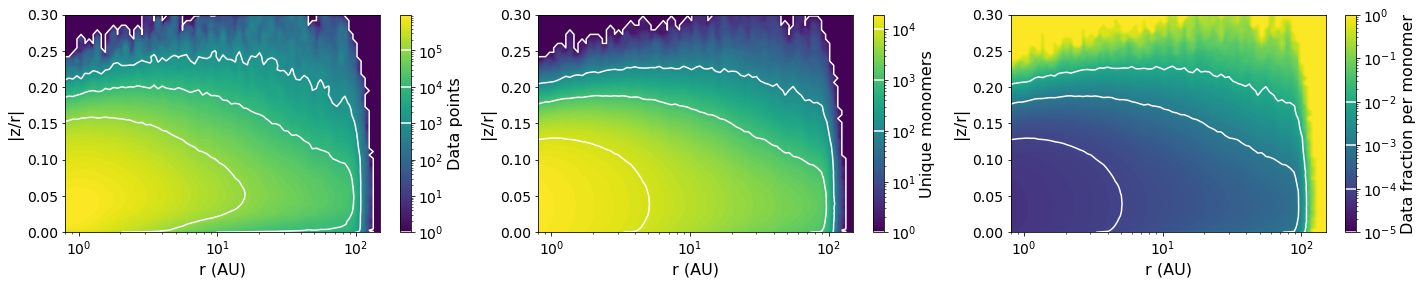

In [7]:
# How well do we populate different disk regions?
# Needs a big (start with 100 000) run (RUN1) with randomly sampled monomers. --> Require position as a function of time.
# Also track number of timesteps --> Number of data points.

def studyPopulation(analysis_name, disk200, loadPath="."):

    fig = figure(figsize=(24,4))
    #fig2 = figure(figsize=(8,4))
    frame1 = fig.add_subplot(1,3,1)
    frame2 = fig.add_subplot(1,3,2)
    frame3 = fig.add_subplot(1,3,3)

    grid = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_nMonData.analysis", "rb")) 
    grid2 = pickle.load(open(loadPath+"/"+analysis_name+"NonLocalCalculations_nMonUniq.analysis", "rb")) 
    
    grid[grid<1] = 1
    grid2[grid2<1] = 1
    
    grid3 = (grid/grid2)/grid
    
    
    
    
    cont1 = frame1.contourf(disk200.model.x,disk200.model.z/disk200.model.x,grid, levels=np.logspace(0,np.log10(grid.max()),100), 
                            norm=colors.LogNorm(vmin=1e0, vmax=grid.max()))
    contl1 = frame1.contour(cont1, levels=[1,1000,1e4,1e5], colors=["w"])
    cbar1 = fig.colorbar(cont1, ticks=[10**n for n in range(-1,10)], extend="max", ax=frame1)
    cbar1.add_lines(contl1)
    cbar1.set_label(label="Data points", size=16)
    cbar1.ax.tick_params(labelsize=14)
    
    
    cont2 = frame2.contourf(disk200.model.x, disk200.model.z/disk200.model.x,grid2, levels=np.logspace(0,np.log10(grid2.max()),100), 
                            norm=colors.LogNorm(vmin=1e0, vmax=grid2.max()))
    cbar2 = fig.colorbar(cont2, ticks=[10**n for n in range(-1,10)], extend="max", ax=frame2)
    contl2 = frame2.contour(cont2, levels=[1,100,1e3,1e4], colors=["w"])
    cbar2.add_lines(contl2)
    cbar2.set_label(label="Unique monomers", size=16)
    cbar2.ax.tick_params(labelsize=14)
    
    cont3 = frame3.contourf(disk200.model.x, disk200.model.z/disk200.model.x,grid3, levels=np.logspace(-5,np.log10(grid3.max()),100), 
                            norm=colors.LogNorm(vmin=1e-5, vmax=grid3.max()))
    cbar3 = fig.colorbar(cont3, ticks=[10**n for n in range(-5,10)], extend="max", ax=frame3)
    contl3 = frame3.contour(cont3, levels=[1e-5,1e-4,1e-3,1e-2], colors=["w"])
    cbar3.add_lines(contl3)
    cbar3.set_label(label="Data fraction per monomer", size=16)
    cbar3.ax.tick_params(labelsize=14)
    
    for frame in [frame1, frame2, frame3]:
        frame.set_xscale("log")
        frame.set_xlabel("r (AU)",fontsize=16)
        frame.tick_params(labelsize=14)
        frame.set_ylabel("|z/r|",fontsize=16)
        frame.set_xlim(0.8,150)
        frame.set_ylim(0,0.3)
    
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"AD"+analysis_name+"DataPoints."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
        #fig2.savefig(pathdict["project"]+"Figures/"+"31"+analysis_name+"UniqueMonomers."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
    
      
    show()
    
    
    
studyPopulation(analysis_name, disk200, loadPath=pathdict["project"])

# What are these bands?

# Appendix E: Typical Stokes numbers

 ------------------------------------------------------------------------ 
|                                                                        |
|                           Welcome to SHAMPOO                           |
|                                                                        |
|                      StocHAstic Monomer PrOcessOr                      |
|                                                                        |
|          Dynamical, collisional and ice processing since 2022          |
|                                                                        |
 ------------------------------------------------------------------------ 
Attempting to load parameters from folder:  /net/zach/data/users/moosterloo/PhD/Papers/ShampooSciencePaper//InputFiles/Section3NonLocal1
Attempt succesful!
Initializing model
Finished model initialization in 0.01 CPU s


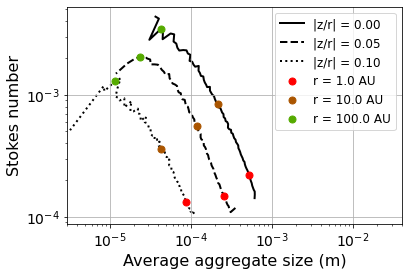

In [6]:
import shampoo

def avgStokes(analysis_name, disk200, loadPath="."):
    """
    Calculates the Stokes number for the mean home aggregate size in the disk midplane, for different heights above
    the disk midplane.
    """
    
    app = "Simulations/NonLocal1"
    #grid_zm = pickle.load(open(loadPath+"/"+app+"/"+analysis_name+"NonLocalCalculations_AVGzMon.analysis", "rb"))
    gridList = pickle.load(open(loadPath+app+"/"+analysis_name+"NonLocalCalculations_AVGsAgg.analysis", "rb"))
    #ratio = grid_zm/grid_sa#= pickle.load(open(loadPath+"/"+app+"/"+analysis_name+"NonLocalCalculations_AVGaggratio.analysis", "rb"))
        
    #gridList = [grid_zm, grid_sa, ratio]
    
    heights = [0,0.05,0.1]
    H = len(heights)
    
    fig = figure(figsize=(6,4))
    frame = fig.add_subplot(1,1,1)
    
    model = shampoo.Model(disk=disk200, parameter_folder=loadPath+"/InputFiles/Section3NonLocal1")
    
    linestyles = ["-","--",":"]
    
    for h in range(H):
        rVals = disk200.model.x[:,0]*model.auTOm
        zVals = rVals*heights[h]
        
        dat_sagg = gridList[:,np.argmin(abs(disk200.model.z[-1,:]/disk200.model.x[-1,:]-heights[h]))] # mean aggregate size as a function r
       
        S = len(dat_sagg)
        dat_stop = np.zeros(S)
        
        
        for s in range(S):

            model.initGradients(size=dat_sagg[s])
            model.probeEnvironment(rVals[s]/model.auTOm, zVals[s]/model.auTOm, 0, inside_loop=False)
            dat_stop[s] = model.Stokes(0,rVals[s],zVals[s], size=dat_sagg[s], rhoMat=2094*float(model.paraDict["phi"]))
        
        frame.loglog(dat_sagg, dat_stop, label="|z/r| = {:.2f}".format(heights[h]), linewidth=2,zorder=-1, color=(0,0,0), linestyle=linestyles[h])
        
        distances = [1,10,100]
        D = len(distances)
        rVals_sagg = np.zeros((D,H))
        rVals_stop = np.zeros((D,H))
        for d in range(D):
            color = ((D-d)/D,d/D,0)
            ind = np.argmin(abs(disk200.model.x[:,0]-distances[d]))
            
            if h==0:
                frame.scatter(dat_sagg[ind], dat_stop[ind], color=color,s=49, label="r = {:.1f} AU".format(distances[d]))
            else:
                frame.scatter(dat_sagg[ind], dat_stop[ind], color=color,s=49)
            rVals_sagg[d,h] = dat_sagg[ind]
            rVals_stop[d,h] = dat_stop[ind]
            
            
  #  for d in range(D):
  #      color = ((D-d)/D,d/D,0)
  #      print(rVals_sagg[d,:])
  #      frame.loglog(rVals_sagg[d,:], rVals_stop[d,:],color=color, linewidth=2)
    
    frame.set_xlabel("Average aggregate size (m)", fontsize=16)
    frame.set_ylabel("Stokes number", fontsize=16)
    frame.grid()
    frame.tick_params(labelsize=14)
    frame.set_xlim(3e-6,4e-2)
    frame.legend(fontsize=12, ncol=1)
    
    for fmt in ["svg","pdf","png"]:
        fig.savefig("./Figures/"+"AE"+analysis_name+"StokesNumbers."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1) 
        
    
    
avgStokes(analysis_name, disk200, loadPath=pathdict["project"])